In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from DN_tools import load_into_pandas, bases_dict, load_recording, get_xy, chunked_test_train_split, plot_glm_filter
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
import os
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, zscore, binned_statistic
import glm_utils.preprocessing, glm_utils.bases
from scipy.stats import pearsonr

plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")

# Functions

In [3]:
def analyze_predictions(y_true, y_pred, n_bins=100, value_range=(-10, 10)):
    """
    Bin y_true into fixed bins, then compute Pearson R and MSE per bin.
    """
    bins = np.linspace(value_range[0], value_range[1], n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_indices = np.digitize(y_true, bins) - 1  # bin index for each sample

    pearson_r = np.full(n_bins, np.nan)
    mse = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)

    for i in range(n_bins):
        idx = bin_indices == i
        counts[i] = np.sum(idx)
        if counts[i] > 2:  # need at least 3 points for correlation
            pearson_r[i] = pearsonr(y_true[idx], y_pred[idx])[0]
            mse[i] = np.mean((y_true[idx] - y_pred[idx])**2)

    return bin_centers, counts, pearson_r, mse

def analyze_predictions_2(y_true, y_pred, n_bins=100, value_range=(-10, 10)):
    """
    Bin y_true into fixed bins, then compute Pearson R and MSE per bin.
    """
    bins = np.linspace(value_range[0], value_range[1], n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_indices = np.digitize(y_true, bins) - 1  # bin index for each sample

    pearson_r = np.full(n_bins, np.nan)
    mse = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)

    for i in range(n_bins):
        idx = bin_indices == i
        counts[i] = np.sum(idx)
        if counts[i] > 2:  # need at least 3 points for correlation
            pearson_r[i] = pearsonr(y_true[idx], y_pred[idx])[0]
            mse[i] = np.mean((y_true[idx] - y_pred[idx])**2)
    probs = counts/np.nanmax(counts)
    return bin_centers, counts, pearson_r, mse, probs

def panel_plot_pooled_analysis(axes,bin_centers, all_counts, all_r, all_mse):

    mean_counts = np.mean(all_counts, axis=0)
    mean_r = np.nanmean(all_r, axis=0)
    mean_mse = np.nanmean(all_mse, axis=0)
    sem_counts = np.nanstd(all_counts, axis=0)/np.sqrt(len(all_counts))
    sem_r = np.nanstd(all_r, axis=0)/np.sqrt(len(all_r))
    sem_mse = np.nanstd(all_mse, axis=0)/np.sqrt(len(all_mse))
    
    axes[0].plot(bin_centers, mean_counts, color="skyblue")
    axes[0].fill_between(bin_centers, mean_counts-sem_counts, mean_counts+sem_counts, alpha=0.5, color="skyblue")
    axes[0].set_ylabel("True data dist\n(density)")
    
    axes[1].plot(bin_centers, mean_r, color="darkgreen")
    axes[1].fill_between(bin_centers, mean_r-sem_r, mean_r+sem_r, alpha=0.5, color="darkgreen")
    axes[1].set_ylabel("Binned pearson R")
    
    axes[2].plot(bin_centers, mean_mse, color="darkred")
    axes[2].fill_between(bin_centers, mean_mse-sem_mse, mean_mse+sem_mse, alpha=0.5, color="darkred")
    axes[2].set_xlabel("True value bins")
    axes[2].set_ylabel("Binned MSE")
    
def get_xcorr(x,y,lag_window_size=30000,normalize_inputs=True):
    if normalize_inputs:
        x = (x - np.mean(x)) / (np.std(x))
        y = (y - np.mean(y)) / (np.std(y))
    xcorr = signal.correlate(x, y, mode='full') / max(len(x),len(y))
    lags = signal.correlation_lags(len(x), len(y))
    lowlim = int(xcorr.shape[0]/2)-lag_window_size
    uplim = int(xcorr.shape[0]/2)+lag_window_size+1
    if xcorr.shape[0] % 1 == 1:
        uplim += 1
    if lag_window_size == -1:
        lowlim, uplim = (0,-1)
    return xcorr[lowlim:uplim], lags[lowlim:uplim]

def rolling_window_traces(plot_df,reference,predicted,bins,rolling_window = 300,analysis_name='continuous_all',raw_data_dir_path = 'W:/apalaci/code/janache'):
    analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
    idx_predicted = analysis_ynames.index(predicted)
    idx_reference = analysis_ynames.index(reference)
    
    final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2
    
    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_m.pkl', 'rb') as handle:
        y_m_dict = pickle.load(handle)
    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_pred.pkl', 'rb') as handle:
        y_pred_dict = pickle.load(handle)

    collected_traces = []
    for _, row in plot_df.iterrows():
        filename = row['filename']

        y_m = y_m_dict[filename]
        y_pred = y_pred_dict[filename]

        if (np.nanstd(y_pred[:,idx_predicted]) < 0.00001):
            print(f"{filename} may have constant prediction")
        else:
            rolling_corr_prediction = pd.Series(y_m[:,idx_predicted]).rolling(window=rolling_window, center=True).corr(pd.Series(y_pred[:,idx_predicted]))
            rolling_mean_fwd = pd.Series(y_m[:,idx_reference]).rolling(window=rolling_window, center=True).mean()
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

            statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            if np.any(~np.isnan(statistic)):
                stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
            else:
                stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
            stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
            stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
            
            collected_traces.append(stat_estimate)
    stack_traces = np.vstack(collected_traces).T
    stack_traces[np.isinf(stack_traces)] = np.nan

    return final_bin_centers, stack_traces

# def matlabs_xcorr(x,y,lag_window_size=30000):
#     x = x / np.linalg.norm(x)
#     y = y / np.linalg.norm(y)
#     xcorr = np.correlate(x,y,mode='full')
#     lags = signal.correlation_lags(len(x), len(y))
#     lowlim = int(xcorr.shape[0]/2)-lag_window_size
#     uplim = int(xcorr.shape[0]/2)+lag_window_size+1
#     if xcorr.shape[0] % 1 == 1:
#         uplim += 1
#     if lag_window_size == -1:
#         lowlim, uplim = (0,-1)
#     return xcorr[lowlim:uplim], lags[lowlim:uplim]

# Cross-Correlations

In [146]:
raw_data_dir_path = 'W:/apalaci/code/janache'
bin_width = 5000; decimating_values = [10,10,10,5] # bin_width = 100; decimating_values = [10,10]
y_names = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang']
y_names_labels = {'v_fwd':'Raw translational velocity','v_ang':'Raw angular velocity','abs_v_fwd':'Abs. translational velocity','abs_v_ang':'Abs. angular velocity'}
sample_frequency = 20000 # 20 Hz

# plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False, 'font.size':15, 'axes.linewidth':2, 'xtick.major.size':5, 'ytick.major.size':5, 'xtick.major.width':2, 'ytick.major.width':2})

In [147]:
# MDNdf = load_into_pandas(dir_path=raw_data_dir_path)
# MDNdf = MDNdf[(MDNdf.to_ignore == False)&(MDNdf.DN == 'MDN')].reset_index(drop=True)
# MDNdf

df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'DopaMeander')].reset_index(drop=True)

df_plot = pd.read_pickle(f'mdn_dm_glms/res/models/df_GLM_results.pkl')
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = df_plot[~((df_plot.DN == 'DopaMeander') & (df_plot.DN_side == 'undefined'))].copy().reset_index(drop=True)
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
filenames_in_plot = df_plot.filename.unique().tolist()

In [7]:
xcorr_left_dict = {yy: [] for yy in y_names}
xcorr_right_dict = {yy: [] for yy in y_names}

for index, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['filename']
    if filename in filenames_in_plot:
        csv_path = row['abs_file_path']
        side = row['side']
        singleDN_df = load_recording(csv_path=csv_path)
        x, ys = get_xy(singleDN_df,y_names,sample_frequency=20000,bin_width=5000,decimating_values=[10,10,10,5])
        
        for iy, yy in enumerate(y_names):
            y = ys[:,iy]
            xcorr, lags = get_xcorr(x,y,lag_window_size=8,normalize_inputs=True)

            if side == 'left':
                xcorr_left_dict[yy].append(xcorr)
            elif side == 'right':
                xcorr_right_dict[yy].append(xcorr)

100%|██████████| 32/32 [09:26<00:00, 17.70s/it]


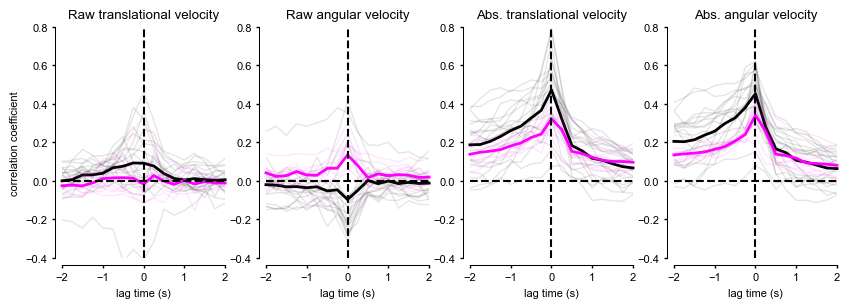

In [ ]:
clip_on = False
time_lags = lags/(sample_frequency/5000)

fig, axes = plt.subplots(1,4,figsize=[10,3])

for iax, yy in enumerate(y_names):
    ax = axes[iax]

    color='k'
    for xcorr in xcorr_right_dict[yy]:
        ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
    mean_trace=  np.nanmean(np.vstack(xcorr_right_dict[yy]),axis=0)
    sem_trace=  np.nanstd(np.vstack(xcorr_right_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_right_dict[yy]).shape[0])
    ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
    # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)
    
    color='magenta'
    for xcorr in xcorr_left_dict[yy]:
        ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
    mean_trace=  np.nanmean(np.vstack(xcorr_left_dict[yy]),axis=0)
    sem_trace=  np.nanstd(np.vstack(xcorr_left_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_left_dict[yy]).shape[0])
    ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
    # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)

    ax.axvline(x=0,c='k',linestyle='--')
    ax.axhline(y=0,c='k',linestyle='--')
    ax.set_xlim([-2,2])
    ax.set_xlabel('lag time (s)')
    ax.set_ylim([-0.4,0.8])

    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([-2,2])
    ax.spines[['left']].set_bounds([-0.4,0.8])
    ax.set_title(y_names_labels[yy])
    
axes[0].set_ylabel('correlation coefficient')
plt.subplots_adjust(wspace=0.25)
# plt.savefig(f'rebuttal_corr_abs_fwd.svg', transparent=False, bbox_inches='tight', dpi=300)
plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# xcorr_comparable_left_dict = {yy: [] for yy in y_names}
# xcorr_comparable_right_dict = {yy: [] for yy in y_names}

# for index, row in tqdm(df.iterrows(), total=len(df)):
#     filename = row['filename']
#     if filename in filenames_in_plot:
#         csv_path = row['abs_file_path']
#         side = row['side']
#         singleDN_df = load_recording(csv_path=csv_path)
#         x, ys = get_xy(singleDN_df,y_names,sample_frequency=20000,bin_width=20000,decimating_values=[10,10,10,10,2])
        
#         for iy, yy in enumerate(y_names):
#             y = ys[:,iy]
#             xcorr, lags = get_xcorr(x,y,lag_window_size=10,normalize_inputs=True)

#             if side == 'left':
#                 xcorr_comparable_left_dict[yy].append(xcorr)
#             elif side == 'right':
#                 xcorr_comparable_right_dict[yy].append(xcorr)

# clip_on = False
# time_lags = lags/(sample_frequency/20000)

# fig, axes = plt.subplots(1,4,figsize=[10,3])

# for iax, yy in enumerate(y_names):
#     ax = axes[iax]

#     color='k'
#     for xcorr in xcorr_comparable_right_dict[yy]:
#         ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
#     mean_trace=  np.nanmean(np.vstack(xcorr_comparable_right_dict[yy]),axis=0)
#     sem_trace=  np.nanstd(np.vstack(xcorr_comparable_right_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_comparable_right_dict[yy]).shape[0])
#     ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
#     # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)
    
#     color='magenta'
#     for xcorr in xcorr_comparable_left_dict[yy]:
#         ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
#     mean_trace=  np.nanmean(np.vstack(xcorr_comparable_left_dict[yy]),axis=0)
#     sem_trace=  np.nanstd(np.vstack(xcorr_comparable_left_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_comparable_left_dict[yy]).shape[0])
#     ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
#     # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)

#     ax.axvline(x=0,c='k',linestyle='--')
#     # ax.set_xlim([-2,2])
#     ax.spines['bottom'].set_position(('outward', 5))
#     # ax.spines[['bottom']].set_bounds([-2,2])
#     ax.set_xlabel('lag time (s)')

#     ax.axhline(y=0,c='k',linestyle='--')
#     ax.set_ylim([-0.4,0.8])
#     ax.spines['left'].set_position(('outward', 5))
#     ax.spines[['left']].set_bounds([-0.4,0.8])

#     ax.set_title(y_names_labels[yy])
# axes[0].set_ylabel('correlation coefficient')
# plt.subplots_adjust(wspace=0.25)
# # plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd_2Hz.png', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()

100%|██████████| 32/32 [04:48<00:00,  9.03s/it]


# new version, per cell

In [155]:
y_names = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang']

df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'DopaMeander')].reset_index(drop=True)

df_plot = pd.read_pickle(f'mdn_dm_glms/res/models/df_GLM_results.pkl')
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = df_plot[~((df_plot.DN == 'DopaMeander') & (df_plot.DN_side == 'undefined'))].copy().reset_index(drop=True)
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
filenames_in_plot = df_plot.filename.unique().tolist()

df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]
unique_IDS = df['unique_id'].unique().tolist()

xcorr_precise_left_dict = {yy: {} for yy in y_names}
xcorr_precise_right_dict = {yy: {} for yy in y_names}

for yy in y_names:
    for unique_id in unique_IDS:
        xcorr_precise_left_dict[yy][unique_id] = []
        xcorr_precise_right_dict[yy][unique_id] = []

for unique_id in tqdm(unique_IDS, total=len(unique_IDS)):
    # print(unique_id)
    unique_df = df.loc[df.unique_id == unique_id].reset_index(drop=True)

    for index, row in unique_df.iterrows():
        filename = row['filename']

        # cellnum = row['#Cell']
        if filename in filenames_in_plot:
            csv_path = row['abs_file_path']
            side = row['side']
            
            singleDN_df = load_recording(csv_path=csv_path)
            x, ys = get_xy(singleDN_df,y_names,sample_frequency=20000,bin_width=100,decimating_values=[10,10])
            
            for iy, yy in enumerate(y_names):
                y = ys[:,iy]
                xcorr, lags = get_xcorr(x,y,lag_window_size=200,normalize_inputs=True)

                if side == 'left':
                    xcorr_precise_left_dict[yy][unique_id].append(xcorr)
                elif side == 'right':
                    xcorr_precise_right_dict[yy][unique_id].append(xcorr)


100%|██████████| 15/15 [05:40<00:00, 22.71s/it]


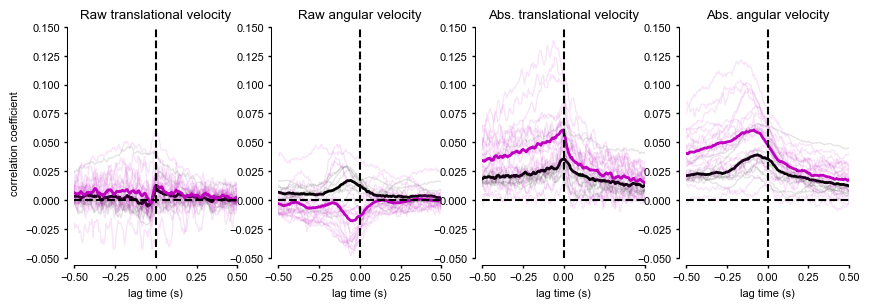

In [ ]:
clip_on = True
time_lags = lags/(sample_frequency/100)

fig, axes = plt.subplots(1,4,figsize=[10,3])

for iax, yy in enumerate(y_names):
    ax = axes[iax]

    for color, xcorr_dict in zip(('k','m'), (xcorr_precise_left_dict, xcorr_precise_right_dict)):
        DN_xcorrs = []
        for unique_id in unique_IDS:
            if len(xcorr_dict[yy][unique_id]) > 0:
                for xcorr_collection in xcorr_dict[yy][unique_id]:
                    xcorr = np.nanmean(np.vstack(xcorr_collection), axis=1)
                    ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
                    DN_xcorrs.append(xcorr)
        mean_trace = np.nanmean(np.vstack(DN_xcorrs), axis=0)
        sem_trace=  np.nanstd(np.vstack(DN_xcorrs) ,axis=0) / np.sqrt(np.vstack(DN_xcorrs).shape[0])
        ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
    
    ax.axvline(x=0,c='k',linestyle='--')
    ax.axhline(y=0,c='k',linestyle='--')
    ax.set_xlim([-0.5,0.5])
    ax.set_xlabel('lag time (s)')
    ax.set_ylim([-0.05,0.15])

    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([-0.5,0.5])
    ax.spines[['left']].set_bounds([-0.05,0.15])
    ax.set_title(y_names_labels[yy])

axes[0].set_ylabel('correlation coefficient')
plt.subplots_adjust(wspace=0.25)
# plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd_precise.svg', transparent=False, bbox_inches='tight', dpi=300)
# plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd_precise.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

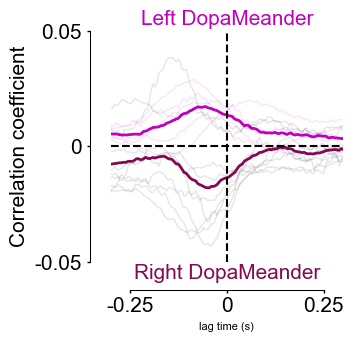

In [ ]:
clip_on = True
time_lags = lags/(sample_frequency/100)
yy = 'v_ang'

plt.figure(figsize=[3,3])
ax = plt.gca()

for color, xcorr_dict in zip(('m','#840950'), (xcorr_precise_left_dict, xcorr_precise_right_dict)):
    DN_xcorrs = []
    for unique_id in unique_IDS:
        xcorr_collection = xcorr_dict[yy][unique_id]
        if len(xcorr_collection) > 0:
            xcorr = np.nanmean(np.vstack(xcorr_collection), axis=0)
            if color == '#840950':
                ax.plot(time_lags, xcorr, alpha=0.1, color='k',lw=1)
            else:
                ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
            DN_xcorrs.append(xcorr)
    mean_trace = np.nanmean(np.vstack(DN_xcorrs), axis=0)
    sem_trace=  np.nanstd(np.vstack(DN_xcorrs) ,axis=0) / np.sqrt(np.vstack(DN_xcorrs).shape[0])
    ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)

ax.axvline(x=0,c='k',linestyle='--')
ax.axhline(y=0,c='k',linestyle='--')
ax.set_xlim([-0.3,0.3])
ax.set_xlabel('lag time (s)')
ax.set_ylim([-0.05,0.05])

ax.spines['bottom'].set_position(('outward', 20))
ax.spines['left'].set_position(('outward', 15))
ax.spines[['bottom']].set_bounds([-0.25,0.25])
ax.spines[['left']].set_bounds([-0.05,0.05])
ax.set_xticks([-0.25,0,0.25],[-0.25,0,0.25],fontsize=15)
ax.set_yticks([-0.05,0,0.05],[-0.05,0,0.05],fontsize=15)
# ax.set_title(y_names_labels[yy])

ax.text(0,0.055,'Left DopaMeander', color='m',ha='center',va='center',fontsize=15)
ax.text(0,-0.055,'Right DopaMeander', color='#840950',ha='center',va='center',fontsize=15)

ax.set_ylabel('Correlation coefficient',fontsize=15)
# plt.subplots_adjust(wspace=0.25)
plt.savefig(f'../fig/rebuttal/rebuttal_DM_timing.png', transparent=False, bbox_inches='tight', dpi=300)
# plt.savefig(f'../fig/rebuttal/rebuttal_DM_timing.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# old version, per trial

In [7]:
xcorr_precise_left_dict = {yy: [] for yy in y_names}
xcorr_precise_right_dict = {yy: [] for yy in y_names}

for index, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['filename']
    if filename in filenames_in_plot:
        csv_path = row['abs_file_path']
        side = row['side']
        singleDN_df = load_recording(csv_path=csv_path)
        x, ys = get_xy(singleDN_df,y_names,sample_frequency=20000,bin_width=100,decimating_values=[10,10])
        
        for iy, yy in enumerate(y_names):
            y = ys[:,iy]
            xcorr, lags = get_xcorr(x,y,lag_window_size=200,normalize_inputs=True)

            if side == 'left':
                xcorr_precise_left_dict[yy].append(xcorr)
            elif side == 'right':
                xcorr_precise_right_dict[yy].append(xcorr)

100%|██████████| 32/32 [32:17<00:00, 60.56s/it] 


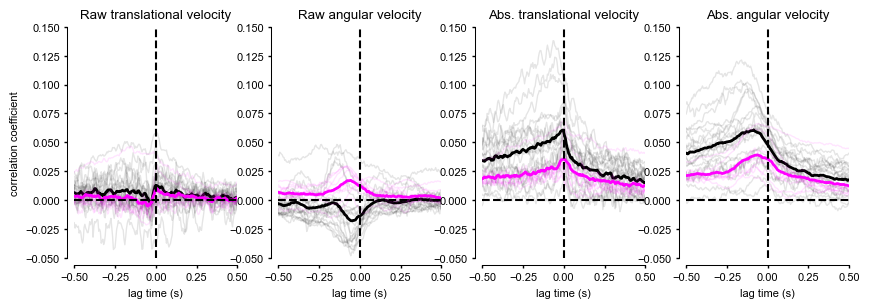

In [ ]:
clip_on = True
time_lags = lags/(sample_frequency/100)

fig, axes = plt.subplots(1,4,figsize=[10,3])

for iax, yy in enumerate(y_names):
    ax = axes[iax]

    color='k'
    for xcorr in xcorr_precise_right_dict[yy]:
        ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
    mean_trace=  np.nanmean(np.vstack(xcorr_precise_right_dict[yy]),axis=0)
    sem_trace=  np.nanstd(np.vstack(xcorr_precise_right_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_precise_right_dict[yy]).shape[0])
    ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
    # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)
    
    color='magenta'
    for xcorr in xcorr_precise_left_dict[yy]:
        ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
    mean_trace=  np.nanmean(np.vstack(xcorr_precise_left_dict[yy]),axis=0)
    sem_trace=  np.nanstd(np.vstack(xcorr_precise_left_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_precise_left_dict[yy]).shape[0])
    ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
    # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)

    ax.axvline(x=0,c='k',linestyle='--')
    ax.axhline(y=0,c='k',linestyle='--')
    ax.set_xlim([-0.5,0.5])
    ax.set_xlabel('lag time (s)')
    ax.set_ylim([-0.05,0.15])

    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([-0.5,0.5])
    ax.spines[['left']].set_bounds([-0.05,0.15])
    ax.set_title(y_names_labels[yy])

axes[0].set_ylabel('correlation coefficient')
plt.subplots_adjust(wspace=0.25)
plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd_precise.svg', transparent=False, bbox_inches='tight', dpi=300)
# plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd_precise.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

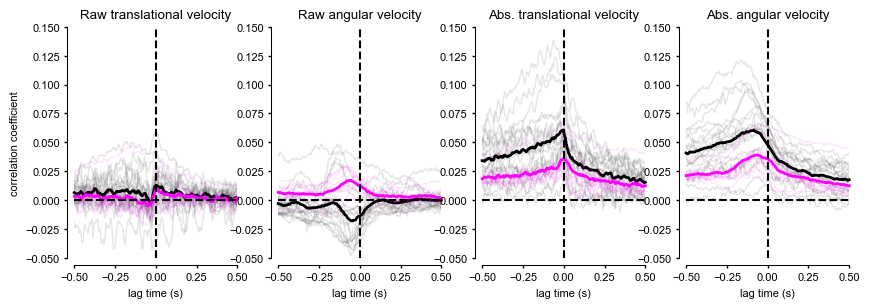

In [ ]:
clip_on = False
time_lags = lags/(sample_frequency/100)
manual_clip_range = slice(100,301)

fig, axes = plt.subplots(1,4,figsize=[10,3])

for iax, yy in enumerate(y_names):
    ax = axes[iax]

    color='k'
    for xcorr in xcorr_precise_right_dict[yy]:
        ax.plot(time_lags[manual_clip_range], xcorr[manual_clip_range], alpha=0.1, color=color,lw=1)
    mean_trace=  np.nanmean(np.vstack(xcorr_precise_right_dict[yy]),axis=0)
    sem_trace=  np.nanstd(np.vstack(xcorr_precise_right_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_precise_right_dict[yy]).shape[0])
    ax.plot(time_lags[manual_clip_range], mean_trace[manual_clip_range], lw=2, color=color, clip_on=clip_on)
    
    color='magenta'
    for xcorr in xcorr_precise_left_dict[yy]:
        ax.plot(time_lags[manual_clip_range], xcorr[manual_clip_range], alpha=0.1, color=color,lw=1)
    mean_trace=  np.nanmean(np.vstack(xcorr_precise_left_dict[yy]),axis=0)
    sem_trace=  np.nanstd(np.vstack(xcorr_precise_left_dict[yy]),axis=0) / np.sqrt(np.vstack(xcorr_precise_left_dict[yy]).shape[0])
    ax.plot(time_lags[manual_clip_range], mean_trace[manual_clip_range], lw=2, color=color, clip_on=clip_on)

    ax.axvline(x=0,c='k',linestyle='--')
    ax.axhline(y=0,c='k',linestyle='--')
    ax.set_xlim([-0.5,0.5])
    ax.set_xlabel('lag time (s)')
    ax.set_ylim([-0.05,0.15])

    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([-0.5,0.5])
    ax.spines[['left']].set_bounds([-0.05,0.15])
    ax.set_title(y_names_labels[yy])

axes[0].set_ylabel('correlation coefficient')
plt.subplots_adjust(wspace=0.25)
# plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd_precise_clipped.svg', transparent=False, bbox_inches='tight', dpi=300)
plt.savefig(f'../fig/rebuttal/rebuttal_corr_abs_fwd_precise_clipped.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Rolling correlation with raw angular velocity

In [53]:
neuron_list =['DN_SPEEDO','MDN','real_DNp17','imposter']  # TO BE CHANGED TO NAME OF NEURONS ACCORDING TO DATA FOLDERS AND INFO TABLES

# fixed color and label parameters (TODO: likely overwritten)
color_perside_dict = {'MDN':'#164CA0','MDN undefined':'#164CA0','imposter left':'#D83288','imposter right':'k', 'DopaMeander left':'#D83288','DopaMeander right':'k','DNp17':'goldenrod','Roadrunner':'SeaGreen'} # probably overwritten at the moment
labels_dict = {'v_fwd':r'$v_{fwd}$','v_ang':r'$v_{ang}$','abs_v_fwd':r'$|v_{fwd}|$','abs_v_ang':r'$|v_{ang}|$','pos_v_fwd':r'$v_{fwd}^+$','pos_v_ang':r'$v_{ang}^+$','neg_v_fwd':r'$v_{fwd}^-$','neg_v_ang':r'$v_{ang}^-$'} # probably overwritten at the moment

# other plotting parameters
first_time = True
cm = 1/2.54
figsize_unit = 3*cm

# downsampling parameters
subsampled_frequency = int(sample_frequency/bin_width)

C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\1792912066.py:51: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\1792912066.py:52: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022_08_18_0000 may have constant prediction
2022_11_25_0012 may have constant prediction
2022_11_25_0013 may have constant prediction
2023_01_26_0006 may have constant prediction
2023_01_26_0020 may have constant prediction
2023_02_21_0006 may have constant prediction
2023_08_11_0009 may have constant prediction
2023_08_15_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\1792912066.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'rebuttal_raw_angular_continuous_corr_NOTNORMALIZED.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


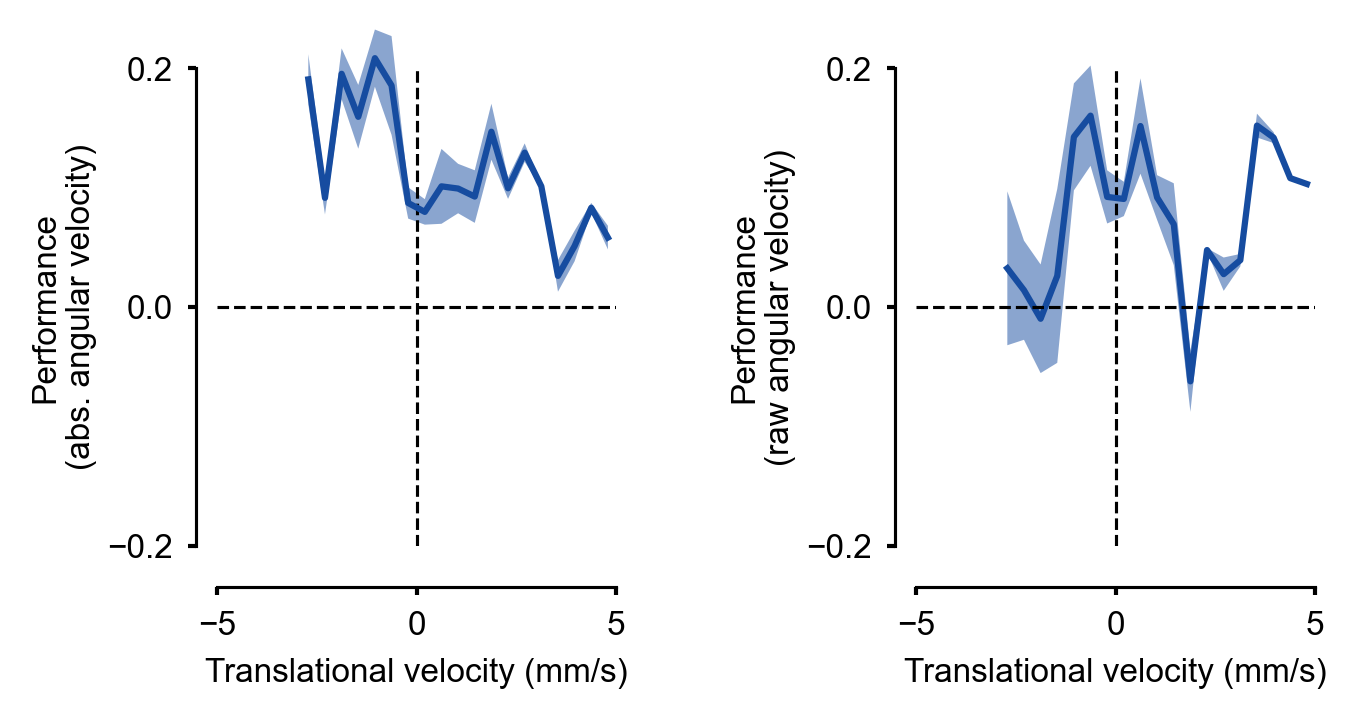

In [ ]:
df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)].reset_index(drop=True)

datadf_plot = df.copy()
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.side == 'undefined'))].reset_index(drop=True)

# plot parameters
normalize_traces = False
ylims = [-0.2,0.2]
clip_on = False
rolling_window = 400
nbins = 25

hspace = 0.75
wspace = 0.75
nrows = 1
ncols = 2
height_ratios = [1+hspace/nrows]*nrows
width_ratios = [1+wspace/ncols]*ncols
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

# panel details
panel_list = [
    ('MDN', 'v_fwd','abs_v_ang', 'Translational velocity (mm/s)', 'Performance\n(abs. angular velocity)', (-5,5)),
    ('MDN', 'v_fwd','v_ang', 'Translational velocity (mm/s)', 'Performance\n(raw angular velocity)', (-5,5)),
    ]

# plot
fig, axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(0.5+sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
axes = axes.flatten()
for iax, (DN, ref_var, pred_var, xlabel, ylabel, xlims) in enumerate(panel_list):
    bins = np.linspace(xlims[0],xlims[1],nbins)
    ax = axes[iax]
    ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
    
    if DN == 'MDN':
        sides = ['undefined']
    else:
        sides = ['left','right']
    
    for side in sides:
        color = color_perside_dict[DN+' '+side]
        selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)

        try:
            final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference=ref_var,predicted=pred_var, bins = bins, rolling_window = rolling_window, analysis_name='continuous_NL_all')
            if normalize_traces:
                stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)
            ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
            ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        except ValueError:
            print('VALUE_ERROR, ', rolling_window, nbins)
            continue

    # general ticks and limits
    ax.set_xlim(xlims)
    ax.set_xticks([xlims[0],0,xlims[1]])
    # ax.set_ylim([-0.05,ylims[1]])
    ax.set_ylim(ylims)
    # ax.set_yticks([-0.2,0,0.2,0.4,0.6,0.8])
    ax.set_yticks([-0.2,0,0.2])
    ax.yaxis.set_label_coords(-0.3, 0.5)
    ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds(xlims)
    ax.spines[['left']].set_bounds(ylims)
    ax.axhline(y=0,color='k',lw=0.75, linestyle='--')

plt.savefig(f'../fig/rebuttal/rebuttal_raw_angular_continuous_corr_NOTNORMALIZED.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\3018693492.py:51: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\3018693492.py:52: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022_08_18_0000 may have constant prediction
2022_11_25_0012 may have constant prediction
2022_11_25_0013 may have constant prediction
2023_01_26_0006 may have constant prediction
2023_01_26_0020 may have constant prediction
2023_02_21_0006 may have constant prediction
2023_08_11_0009 may have constant prediction
2023_08_15_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\3018693492.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'rebuttal_raw_angular_continuous_corr.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


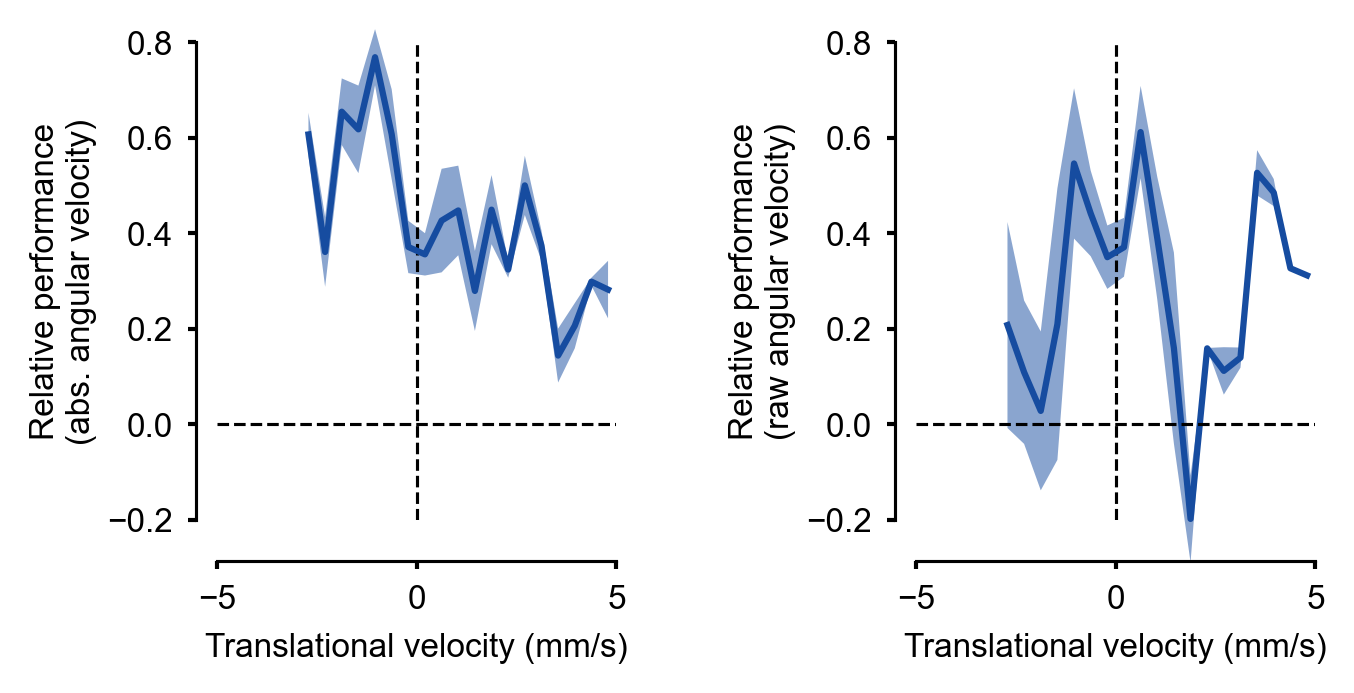

In [ ]:
df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)].reset_index(drop=True)

datadf_plot = df.copy()
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.side == 'undefined'))].reset_index(drop=True)

# plot parameters
normalize_traces = True
ylims = [-0.2,0.8]
clip_on = False
rolling_window = 400
nbins = 25

hspace = 0.75
wspace = 0.75
nrows = 1
ncols = 2
height_ratios = [1+hspace/nrows]*nrows
width_ratios = [1+wspace/ncols]*ncols
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

# panel details
panel_list = [
    ('MDN', 'v_fwd','abs_v_ang', 'Translational velocity (mm/s)', 'Relative performance\n(abs. angular velocity)', (-5,5)),
    ('MDN', 'v_fwd','v_ang', 'Translational velocity (mm/s)', 'Relative performance\n(raw angular velocity)', (-5,5)),
    ]

# plot
fig, axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(0.5+sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
axes = axes.flatten()
for iax, (DN, ref_var, pred_var, xlabel, ylabel, xlims) in enumerate(panel_list):
    bins = np.linspace(xlims[0],xlims[1],nbins)
    ax = axes[iax]
    ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
    
    if DN == 'MDN':
        sides = ['undefined']
    else:
        sides = ['left','right']
    
    for side in sides:
        color = color_perside_dict[DN+' '+side]
        selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)

        try:
            final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference=ref_var,predicted=pred_var, bins = bins, rolling_window = rolling_window, analysis_name='continuous_NL_all')
            if normalize_traces:
                stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)
            ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
            ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        except ValueError:
            print('VALUE_ERROR, ', rolling_window, nbins)
            continue

    # general ticks and limits
    ax.set_xlim(xlims)
    ax.set_xticks([xlims[0],0,xlims[1]])
    # ax.set_ylim([-0.05,ylims[1]])
    ax.set_ylim(ylims)
    ax.set_yticks([-0.2,0,0.2,0.4,0.6,0.8])
    ax.yaxis.set_label_coords(-0.3, 0.5)
    ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds(xlims)
    ax.spines[['left']].set_bounds(ylims)
    ax.axhline(y=0,color='k',lw=0.75, linestyle='--')

plt.savefig(f'../fig/rebuttal/rebuttal_raw_angular_continuous_corr.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Velocity balance

In [5]:
bin_width = 100; decimating_values = [10,10]
y_names = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang']
block_size = 5_000; n_block_min=5; test_size = 0.35; random_state = 42; starting_nbins = 32
window = bases_dict['window']

In [15]:
nbins = 100
y_bins_dict = {'v_fwd': (-5,5),'abs_v_fwd': (0,5),'v_ang':(-200,200),'abs_v_ang': (0,200)}

df = load_into_pandas(dir_path=raw_data_dir_path)
df = df[df.to_ignore == False].reset_index(drop=True)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[~((df.DN == 'DopaMeander') & (df.side == 'undefined'))].reset_index(drop=True)
df = df[df.DN.isin(['MDN','DopaMeander'])].reset_index(drop=True)

B = glm_utils.bases.raised_cosine(neye = bases_dict['neye'], ncos = bases_dict['ncos'], kpeaks = bases_dict['kpeaks'], b = bases_dict['b'], nbasis = bases_dict['nbasis'])
B = B[-window:]
basis_projection = glm_utils.preprocessing.BasisProjection(B)

H_full_dict = {DN: {yy: [] for yy in y_names} for DN in ['MDN','DopaMeander']}
H_train_dict = {DN: {yy: [] for yy in y_names} for DN in ['MDN','DopaMeander']}
H_test_dict = {DN: {yy: [] for yy in y_names} for DN in ['MDN','DopaMeander']}

# smaller_df = df.iloc[:5]
for index, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['filename']
    csv_path = row['abs_file_path']
    DN = row['DN']

    singleDN_df = load_recording(csv_path=csv_path)

    x, ys = get_xy(singleDN_df,y_names)

    X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
    X_b = basis_projection.transform(X)

    X_train, X_test, y_train, y_test = chunked_test_train_split(X_b,y_m,block_size=block_size,n_block_min=n_block_min,test_size=test_size,random_state=random_state)

    for iy, yname in enumerate(y_names):
        H, _ = np.histogram(y_m[:,iy],bins=np.linspace(*y_bins_dict[yname],nbins),density=True)
        H_full_dict[DN][yname].append(H)

        H, _ = np.histogram(y_train[:,iy],bins=np.linspace(*y_bins_dict[yname],nbins),density=True)
        H_train_dict[DN][yname].append(H)

        H, _ = np.histogram(y_test[:,iy],bins=np.linspace(*y_bins_dict[yname],nbins),density=True)
        H_test_dict[DN][yname].append(H)

 19%|█▉        | 10/52 [01:40<04:17,  6.13s/it]

RECORDING TOO SMALL, NOT CHUNKING


 50%|█████     | 26/52 [04:49<03:09,  7.28s/it]

RECORDING TOO SMALL, NOT CHUNKING


 58%|█████▊    | 30/52 [06:29<05:14, 14.28s/it]

RECORDING TOO SMALL, NOT CHUNKING


 62%|██████▏   | 32/52 [06:34<02:46,  8.33s/it]

RECORDING TOO SMALL, NOT CHUNKING


 73%|███████▎  | 38/52 [07:18<01:32,  6.62s/it]

RECORDING TOO SMALL, NOT CHUNKING


 79%|███████▉  | 41/52 [07:47<01:18,  7.14s/it]

RECORDING TOO SMALL, NOT CHUNKING


 90%|█████████ | 47/52 [08:41<00:36,  7.23s/it]

RECORDING TOO SMALL, NOT CHUNKING


 92%|█████████▏| 48/52 [08:44<00:23,  5.87s/it]

RECORDING TOO SMALL, NOT CHUNKING


100%|██████████| 52/52 [09:47<00:00, 11.29s/it]


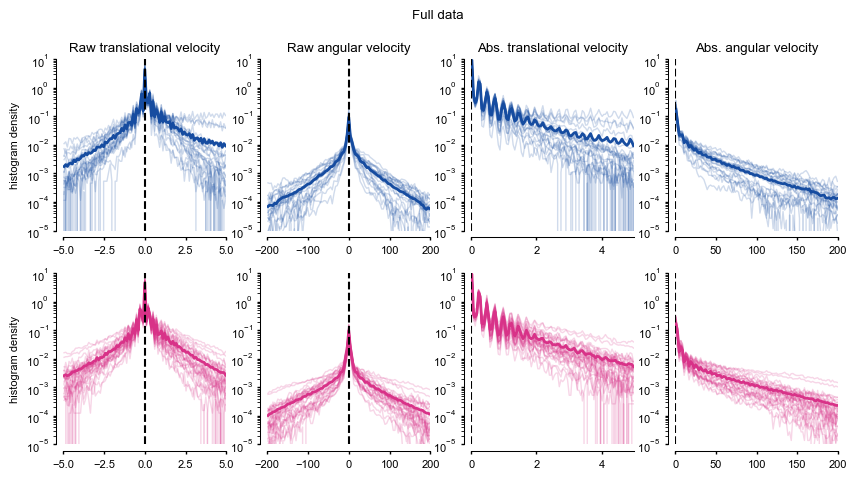

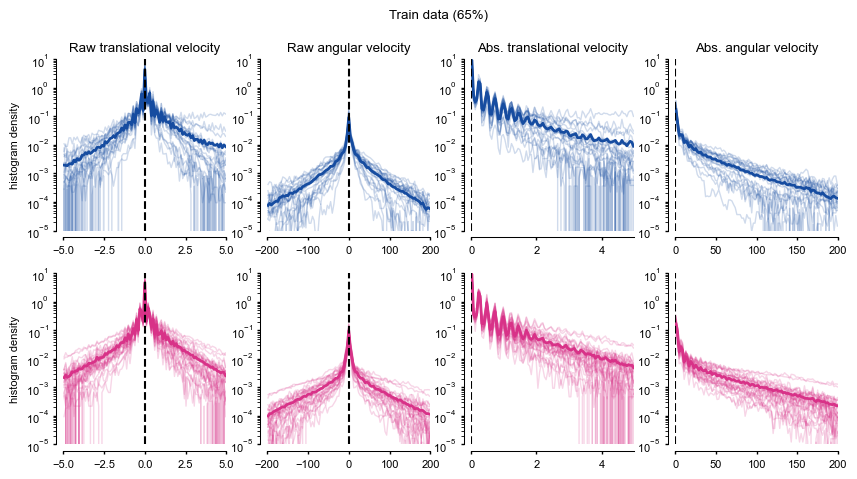

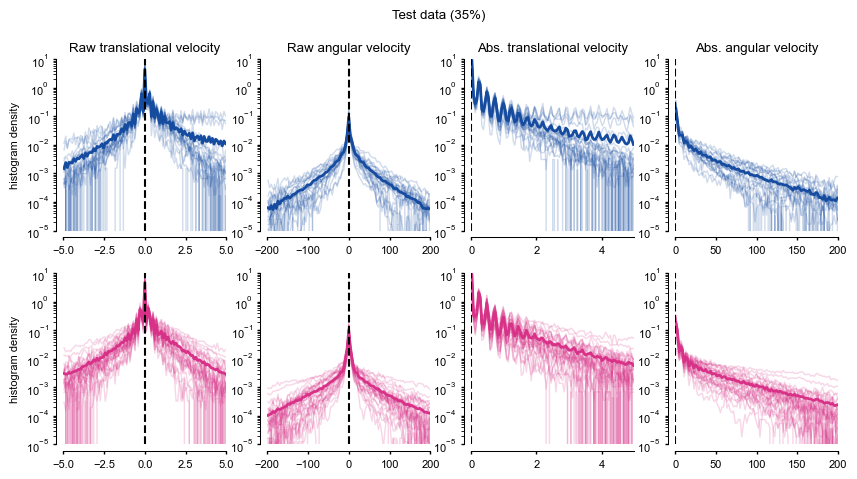

In [ ]:
x_axis_variable_dict = {yname: (np.linspace(*y_bins_dict[yname],nbins)[1:]+np.linspace(*y_bins_dict[yname],nbins)[:-1])/2 for yname in y_names}
clip_on = True
ylims = [0.00001,10]

for filelabel, title, H_dict_class in zip(['Full', 'Train', 'Test'],['Full data', 'Train data (65%)', 'Test data (35%)'],[H_full_dict, H_train_dict, H_test_dict]):
    fig, axes = plt.subplots(2,4,figsize=[10,5])

    for iax, yy in enumerate(y_names):
        for iDN, DN, color in zip(range(2),['MDN','DopaMeander'],['#164CA0', '#D83288']):
            H_dict = H_dict_class[DN]
            ax = axes[iDN,iax]

            for hh in H_dict[yy]:
                ax.plot(x_axis_variable_dict[yy], hh, alpha=0.2, color=color,lw=1)
            mean_trace=  np.nanmean(np.vstack(H_dict[yy]),axis=0)
            sem_trace=  np.nanstd(np.vstack(H_dict[yy]),axis=0) / np.sqrt(np.vstack(H_dict[yy]).shape[0])
            ax.plot(x_axis_variable_dict[yy], mean_trace, lw=2, color=color, clip_on=clip_on)
            # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)

    for iax, yy in enumerate(y_names):
        for ax in axes[:,iax].flatten():
            ax.set_xlim(y_bins_dict[yy])
            ax.spines['left'].set_bounds(y_bins_dict[yy])
        axes[0,iax].set_title(y_names_labels[yy])

    for ax in axes.flatten():
        ax.axvline(x=0,c='k',linestyle='--')
        # ax.axhline(y=0,c='k',linestyle='--')
        ax.set_ylim(ylims)
        ax.set_yscale('log')
        ax.spines['left'].set_bounds(ylims)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))

    for iDN in range(2):
        axes[iDN,0].set_ylabel('histogram density')

    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.suptitle(title)
    plt.savefig(f'../fig/rebuttal/rebuttal_balance_{filelabel}.png', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()

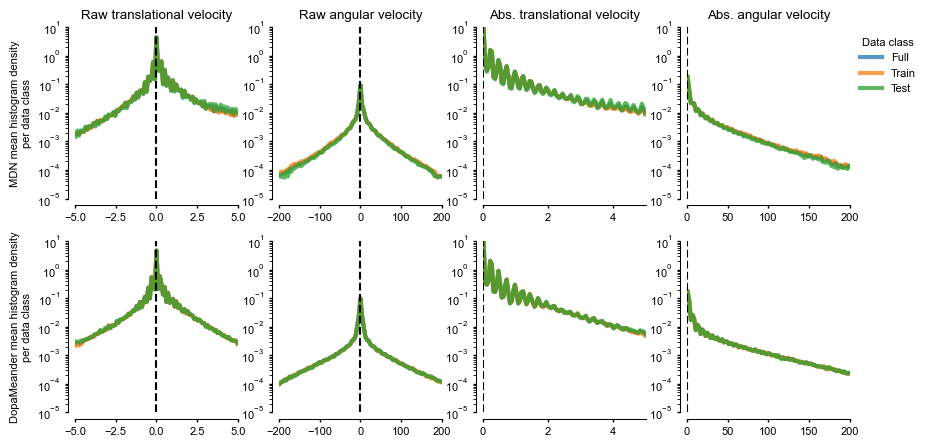

In [ ]:
x_axis_variable_dict = {yname: (np.linspace(*y_bins_dict[yname],nbins)[1:]+np.linspace(*y_bins_dict[yname],nbins)[:-1])/2 for yname in y_names}
clip_on = True
ylims = [0.00001,10]

fig, axes = plt.subplots(2,4,figsize=[10,5])
for filelabel, title, H_dict_class in zip(['Full', 'Train', 'Test'],['Full data', 'Train data (65%)', 'Test data (35%)'],[H_full_dict, H_train_dict, H_test_dict]):
    for iax, yy in enumerate(y_names):
        for iDN, DN in zip(range(2),['MDN','DopaMeander']):
            H_dict = H_dict_class[DN]
            ax = axes[iDN,iax]

            # for hh in H_dict[yy]:
            #     ax.plot(x_axis_variable_dict[yy], hh, alpha=0.2, color=color,lw=1)
            mean_trace=  np.nanmean(np.vstack(H_dict[yy]),axis=0)
            # sem_trace=  np.nanstd(np.vstack(H_dict[yy]),axis=0) / np.sqrt(np.vstack(H_dict[yy]).shape[0])
            ax.plot(x_axis_variable_dict[yy], mean_trace, lw=3, alpha=0.75, clip_on=clip_on, label=filelabel)
            # ax.fill_between(time_lags, mean_trace-sem_trace, mean_trace+sem_trace, edgecolor=None, facecolor=color, alpha=0.2, clip_on=clip_on)

for iax, yy in enumerate(y_names):
    for ax in axes[:,iax].flatten():
        ax.set_xlim(y_bins_dict[yy])
        ax.spines['left'].set_bounds(y_bins_dict[yy])
    axes[0,iax].set_title(y_names_labels[yy])

for ax in axes.flatten():
    ax.axvline(x=0,c='k',linestyle='--')
    # ax.axhline(y=0,c='k',linestyle='--')
    ax.set_ylim(ylims)
    ax.set_yscale('log')
    ax.spines['left'].set_bounds(ylims)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))

for iDN, DN in enumerate(['MDN','DopaMeander']):
    axes[iDN,0].set_ylabel(f'{DN} mean histogram density\nper data class')

axes[0,3].legend(bbox_to_anchor=(1., 1.), frameon=False, title='Data class', loc='upper left')

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig(f'../fig/rebuttal/rebuttal_balance_overlapped.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Cleaner velocity balance

In [7]:
bin_width = 100; decimating_values = [10,10]
y_names = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang']
block_size = 5_000; n_block_min=5; test_size = 0.35; random_state = 42; starting_nbins = 32
window = bases_dict['window']

nbins = 100
y_bins_dict = {'v_fwd': (-5,5),'abs_v_fwd': (0,5),'v_ang':(-200,200),'abs_v_ang': (0,200)}

df = load_into_pandas(dir_path=raw_data_dir_path)
df = df[df.to_ignore == False].reset_index(drop=True)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[~((df.DN == 'DopaMeander') & (df.side == 'undefined'))].reset_index(drop=True)
df = df[df.DN.isin(['MDN'])].reset_index(drop=True)
df


,filename,#Fly,#Trial,#Cell,side,DN,to_ignore,abs_file_path
0,2022_08_18_0000,1.0,1.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2022_08_18_0000.csv
1,2022_09_12_0000,2.0,1.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2022_09_12_0000.csv
2,2022_11_25_0009,3.0,1.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2022_11_25_0009.csv
3,2022_11_25_0011,3.0,2.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2022_11_25_0011.csv
4,2022_11_25_0012,3.0,3.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2022_11_25_0012.csv
5,2022_11_25_0013,3.0,4.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2022_11_25_0013.csv
6,2023_01_23_0010,4.0,1.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2023_01_23_0010.csv
7,2023_01_23_0014,4.0,2.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2023_01_23_0014.csv
8,2023_01_26_0004,5.0,1.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2023_01_26_0004.csv
9,2023_01_26_0006,5.0,2.0,1.0,undefined,MDN,False,W:/apalaci/code/janache/MDN/2023_01_26_0006.csv


In [13]:
raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
isplit = 0
varname = 'v_fwd'

index = 5
row = df.iloc[index]

# for index, row in df.iterrows():
filename = row['filename']
DN_side = row['side']
DN = row['DN']

res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
if os.path.exists(res_file_path):
    # for isplit in range(nsplits):
    with open(res_file_path, 'rb') as handle:
        temp = pickle.load(handle)

        y_test = temp['y_test']
        y_train = temp['y_train']
        y_pred_test_nl = temp['y_pred_test_nl']
        y_pred_test = temp['y_pred_test']

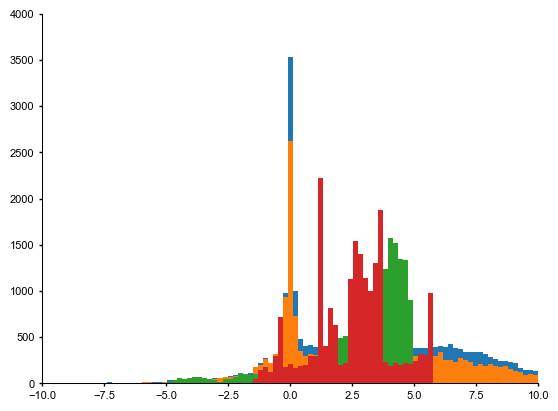

In [14]:
plt.hist(y_train,bins=np.linspace(-10,10,100))
plt.hist(y_test,bins=np.linspace(-10,10,100))
plt.hist(y_pred_test,bins=np.linspace(-10,10,100))
plt.hist(y_pred_test_nl,bins=np.linspace(-10,10,100))
plt.show()

C:\Users\apalaci\AppData\Local\Temp\ipykernel_12780\2908020522.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r[i] = pearsonr(y_true[idx], y_pred[idx])[0]


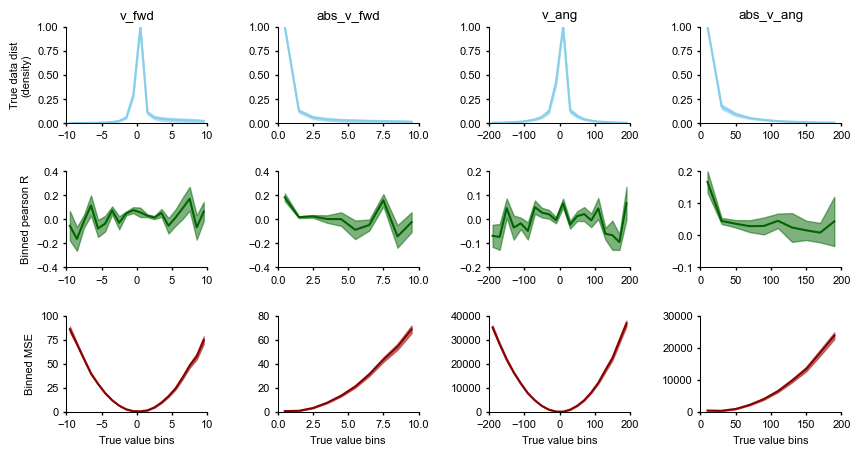

In [ ]:
plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")
raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
isplit = 0
value_range_dict = {'v_fwd':(-10,10),'abs_v_fwd':(0,10),'v_ang':(-200,200),'abs_v_ang':(0,200)}
n_bins_dict = {'v_fwd':20,'abs_v_fwd':10,'v_ang':20,'abs_v_ang':10}

fig, axes = plt.subplots(3, 4, figsize=(10,5))

for iv, varname in enumerate(['v_fwd','abs_v_fwd','v_ang','abs_v_ang']):
    all_counts, all_r, all_mse, all_probs = [], [], [], []
    for index, row in df.iterrows():
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']

        res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
        if os.path.exists(res_file_path):
            with open(res_file_path, 'rb') as handle:
                temp = pickle.load(handle)

                y_test = temp['y_test']
                y_pred_test_nl = temp['y_pred_test_nl']

            bin_centers, counts, pearson_r, mse, probs = analyze_predictions_2(y_test, y_pred_test_nl, n_bins=n_bins_dict[varname], value_range=value_range_dict[varname])
            all_counts.append(counts)
            all_probs.append(probs)
            all_r.append(pearson_r)
            all_mse.append(mse)

    panel_plot_pooled_analysis(axes[:,iv], bin_centers, all_probs, all_r, all_mse)
    axes[0,iv].set_title(varname)
for ax in axes[:,1:].flatten():
    ax.set_ylabel('')

plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.savefig(f'../fig/rebuttal/rebuttal_binned_stats.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Nonlinearities

In [3]:
isplit = 0
redo_analysis = False
bin_width = 100
decimating_values = [10,10]
starting_nbins = 50
raw_data_dir_path = 'W:/apalaci/code/janache'
# y_names = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang']
# y_names_labels = {'v_fwd':'Raw translational velocity','v_ang':'Raw angular velocity','abs_v_fwd':'Abs. translational velocity','abs_v_ang':'Abs. angular velocity'}
sample_frequency = 20000 # 20 Hz
subsampled_frequency = int(sample_frequency/bin_width)

In [ ]:
results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
plot_upscale_factor = 0.25
nbins = 50
# y_names = ['v_fwd','abs_v_fwd','neg_v_fwd','pos_v_fwd','v_ang','abs_v_ang','neg_v_ang','pos_v_ang']
y_names = ['v_fwd','abs_v_fwd','neg_v_fwd','pos_v_fwd']
T = np.arange(-int(3*subsampled_frequency), 0)/subsampled_frequency
score_threshold = 0.25
# value_range_dict = {'v_fwd':(-5,5),'abs_v_fwd':(0,5), 'neg_v_fwd':(-5,0), 'pos_v_fwd':(0,5),'v_ang':(-30,30),'abs_v_ang':(0,30), 'neg_v_ang':(-30,0), 'pos_v_ang':(0,30)}
fwd_range = (-5,5)
ang_range = (-100,100)
value_range_dict = {'v_fwd':fwd_range,'abs_v_fwd':fwd_range, 'neg_v_fwd':fwd_range, 'pos_v_fwd':fwd_range,'v_ang':ang_range,'abs_v_ang':ang_range, 'neg_v_ang':ang_range, 'pos_v_ang':ang_range}

fwd_lim = (-0.15,0.15)
ang_lim = (-3,3)
filter_limits_dict = {'v_fwd':fwd_lim,'abs_v_fwd':fwd_lim, 'neg_v_fwd':fwd_lim, 'pos_v_fwd':fwd_lim,'v_ang':ang_lim,'abs_v_ang':ang_lim, 'neg_v_ang':ang_lim, 'pos_v_ang':ang_lim}

df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'MDN')].reset_index(drop=True)
df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]
unique_IDS = df['unique_id'].unique().tolist()

df_GLMresults = pd.read_pickle(f'../res/models/df_GLM_results.pkl')
df_GLMresults = df_GLMresults[df_GLMresults.DN == 'MDN']
df_GLMresults['unique_id'] = [df.loc[df.filename == ff,'unique_id'].values[0] for ff in df_GLMresults['filename']]
if score_threshold > 0:
    unique_IDS = df_GLMresults[df_GLMresults.pearsonr_score > score_threshold].unique_id.unique().tolist()

collected_filters_dict = {varname: {} for varname in y_names}
for varname in y_names:
    for unique_id in unique_IDS:
        collected_filters_dict[varname][unique_id] = []

collected_nls_dict = {varname: {} for varname in y_names}
for varname in y_names:
    for unique_id in unique_IDS:
        collected_nls_dict[varname][unique_id] = {}
        collected_nls_dict[varname][unique_id]['statistic_mean'] = []
        collected_nls_dict[varname][unique_id]['statistic_mean_afternl'] = []

for varname in y_names:
    plot_upscale = plot_upscale_factor*(value_range_dict[varname][1] - value_range_dict[varname][0])
    xmin = value_range_dict[varname][0] - plot_upscale
    xmax = value_range_dict[varname][1] + plot_upscale
    for unique_id in tqdm(unique_IDS, total=len(unique_IDS)):
        unique_df = df.loc[df.unique_id == unique_id].reset_index(drop=True)
        
        trial_prediction = []
        trial_statistics = []
        estimated_filters_list = []
        for index, row in unique_df.iterrows():
            filename = row['filename']
            res_file_path = f'{raw_data_dir_path}/res/2025_glms_doublecheck_NL/{filename}_{varname}_isplit0.pkl'
            if os.path.exists(res_file_path):
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    estimated_filters_list.append(temp['estimated_filters'][:])
                    y_pred_train = temp['y_pred_train'][:]
                    y_train = temp['y_train'][:]
                    y_pred_test = temp['y_pred_test'][:]
                    
                    bin_edges_fixed = np.linspace(xmin, xmax, nbins)

                    statistic, bin_edges, binnumber = binned_statistic(y_pred_train, y_train, statistic='mean', bins=bin_edges_fixed, range=None)
                    bin_centers = bin_edges[:-1] + np.mean(np.diff(bin_edges)) / 2

                    valid = ~np.isnan(statistic)
                    x = bin_centers[valid]
                    y = statistic[valid]
                    y_interp = np.interp(y_pred_test, x, y)
                    outside = (y_pred_test < x.min()) | (y_pred_test > x.max())
                    y_interp[outside] = y_pred_test[outside]
                    y_pred_test_nl = y_interp
                    statistic_nl, _, _ = binned_statistic(y_pred_test, y_pred_test_nl, statistic='mean', bins=bin_edges_fixed, range=None)

                    trial_statistics.append(statistic)
                    trial_prediction.append(statistic_nl)

        collected_filters_dict[varname][unique_id] = np.nanmean(np.vstack(estimated_filters_list),axis=0)

        collected_nls_dict[varname][unique_id]['statistic_mean'].append(np.nanmean(np.vstack(trial_statistics),axis=0))
        collected_nls_dict[varname][unique_id]['statistic_mean_afternl'].append(np.nanmean(np.vstack(trial_prediction),axis=0))

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\1989768965.py:82: RuntimeWarning: Mean of empty slice
  collected_nls_dict[varname][unique_id]['statistic_mean'].append(np.nanmean(np.vstack(trial_statistics),axis=0))
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\1989768965.py:83: RuntimeWarning: Mean of empty slice
  collected_nls_dict[varname][unique_id]['statistic_mean_afternl'].append(np.nanmean(np.vstack(trial_prediction),axis=0))
100%|██████████| 12/12 [00:03<00:00,  3.61it/s]


C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\1245673701.py:32: RuntimeWarning: Mean of empty slice
  mean_statistic = np.nanmean(np.vstack(collected_nls_dict[varname][unique_id]['statistic_mean_afternl']),axis=0)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\1245673701.py:35: RuntimeWarning: Mean of empty slice
  mean_mean_statistic = np.nanmean(np.vstack(mean_statistic_list),axis=0)


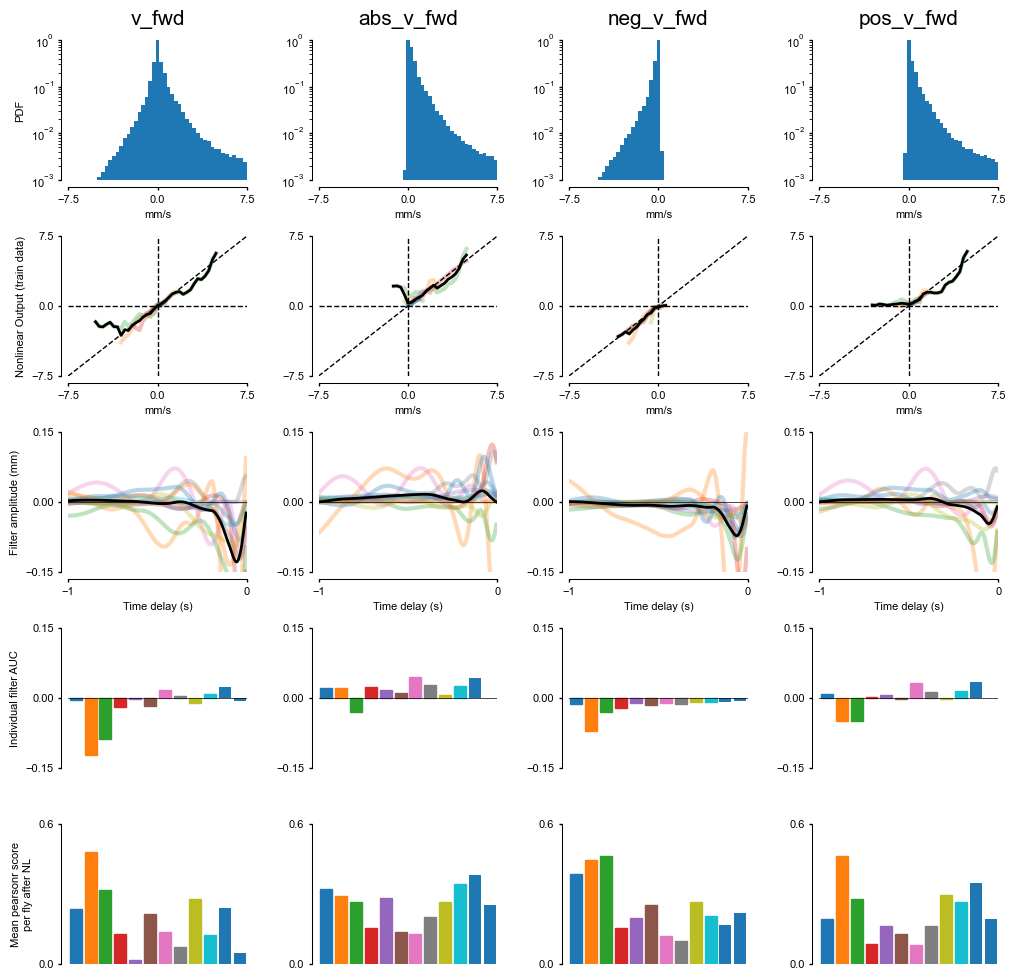

In [ ]:
fig, axes = plt.subplots(5,len(y_names),figsize=(3*len(y_names),12))

for iv, varname in enumerate(y_names):

    plot_upscale = plot_upscale_factor*(value_range_dict[varname][1] - value_range_dict[varname][0])
    xmin = value_range_dict[varname][0] - plot_upscale
    xmax = value_range_dict[varname][1] + plot_upscale

    ax = axes[0,iv]
    bin_edges_fixed = np.linspace(xmin, xmax, nbins)
    all_y_test = []
    for index, row in df.iterrows():
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']
        res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
        if os.path.exists(res_file_path):
            with open(res_file_path, 'rb') as handle:
                temp = pickle.load(handle)
                all_y_test.append(temp['y_test'])
    ax.hist(np.hstack(all_y_test), bins = bin_edges_fixed, density=True)
    ax.set_xlim([xmin, xmax])
    ax.set_yscale('log')
    ax.set_ylim([0.001,1])
    ax.set_title(varname,y=1.05,fontsize=15)

    ax = axes[1,iv]
    bin_edges_fixed = np.linspace(xmin, xmax, nbins)
    bin_centers = bin_edges_fixed[:-1] + np.mean(np.diff(bin_edges_fixed)) / 2
    mean_statistic_list = []
    for unique_id in unique_IDS:
        mean_statistic = np.nanmean(np.vstack(collected_nls_dict[varname][unique_id]['statistic_mean_afternl']),axis=0)
        mean_statistic_list.append(mean_statistic)
        ax.plot(bin_centers, mean_statistic, lw=3, alpha=0.3, label='Nonlinearity')
    mean_mean_statistic = np.nanmean(np.vstack(mean_statistic_list),axis=0)
    ax.plot(bin_centers, mean_mean_statistic, 'k', lw=2, alpha=1, label='Nonlinearity')
    ax.plot([xmin, xmax], [xmin, xmax], 'k', lw=1, alpha=1, linestyle='--')
    ax.axhline(y=0, color='k', lw=1, linestyle='--')
    ax.axvline(x=0, color='k', lw=1, linestyle='--')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])

    ax = axes[2,iv]
    mean_flyfilter_list = []
    for unique_id in unique_IDS:
        mean_flyfilter = np.nanmean(np.vstack(collected_filters_dict[varname][unique_id]),axis=1)
        mean_flyfilter_list.append(mean_flyfilter)
        ax.plot(T, mean_flyfilter, lw=3, alpha=0.3, label='Fly filter')
    mean_filter = np.nanmean(np.vstack(mean_flyfilter_list),axis=0)
    ax.plot(T, mean_filter, 'k', lw=2, alpha=1, label='Mean filter')
    ax.axhline(y=0,color='k',lw=0.5)
    ax.set_ylim(filter_limits_dict[varname])

    ax = axes[3,iv]
    areas = [np.trapezoid(f, 3+T) for f in mean_flyfilter_list]
    bars = ax.bar(range(len(mean_flyfilter_list)), areas)
    for bar, color in zip(bars, plt.rcParams['axes.prop_cycle'].by_key()['color']):
        bar.set_color(color)
    ax.axhline(y=0,color='k',lw=0.5)
    # ax.set_xlabel('Individual model filters')
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = axes[4,iv]   
    scores_list = [df_GLMresults[(df_GLMresults.unique_id == uID) & (df_GLMresults.varname == varname)]['pearsonr_score'].mean() for uID in unique_IDS]
    bars = ax.bar(range(len(scores_list)), scores_list)
    for bar, color in zip(bars, plt.rcParams['axes.prop_cycle'].by_key()['color']):
        bar.set_color(color)
    ax.axhline(y=0,color='k',lw=0.5)
    # ax.set_xlabel('Individual model scores')
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0,0].set_ylabel('PDF')
axes[1,0].set_ylabel('Nonlinear Output (train data)')
axes[0,0].set_ylabel('PDF')
axes[2,0].set_ylabel('Filter amplitude (mm)')
axes[3,0].set_ylabel('Individual filter AUC')
axes[4,0].set_ylabel('Mean pearsonr score\nper fly after NL')
# axes[2,4].set_ylabel('Filter amplitude (°)')

for ax in axes[0,:].flatten():
    ax.set_xlabel('')
for ax in axes[:2,:4].flatten():
    ax.set_xlabel('mm/s')
for ax in axes[:2,4:].flatten():
    ax.set_xlabel('°/s')
for ax in axes[2,:].flatten():
    ax.set_xlabel('Time delay (s)')
    ax.set_xlim([-1,0])

for iv, varname in enumerate(y_names):
    plot_upscale = plot_upscale_factor*(value_range_dict[varname][1] - value_range_dict[varname][0])
    xmin = value_range_dict[varname][0] - plot_upscale
    xmax = value_range_dict[varname][1] + plot_upscale

    ax = axes[0,iv]
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([xmin,xmax])
    ax.set_xticks([xmin,0,xmax])
    ax.spines[['left']].set_bounds([0.001,1])
    # ax.set_yticks([0.001,1])

    ax = axes[1,iv]
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([xmin,xmax])
    ax.set_xticks([xmin,0,xmax])
    ax.spines[['left']].set_bounds([xmin,xmax])
    ax.set_yticks([xmin,0,xmax])

    ax = axes[2,iv]
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([-1,0])
    ax.set_xticks([-1,0])
    ax.spines[['left']].set_bounds(filter_limits_dict[varname])
    ax.set_yticks([filter_limits_dict[varname][0],0,filter_limits_dict[varname][1]])

    ax = axes[3,iv]
    ax.set_xlim([-0.5,len(unique_IDS)-0.5])
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.set_ylim(filter_limits_dict[varname])
    ax.set_yticks([filter_limits_dict[varname][0],0,filter_limits_dict[varname][1]])
    ax.spines[['left']].set_bounds(filter_limits_dict[varname])

    scores_limits = (0,0.6)
    ax = axes[4,iv]
    ax.set_xlim([-0.5,len(unique_IDS)-0.5])
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.set_ylim(scores_limits)
    ax.set_yticks([0,scores_limits[1]])
    ax.spines[['left']].set_bounds(scores_limits)

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.savefig(f'../fig/rebuttal/MDN_vdistribution_NL_filter_AUC.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\3523374176.py:101: RuntimeWarning: Mean of empty slice
  statistic_mean = np.nanmean(np.vstack(trial_statistics),axis=0)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\3523374176.py:102: RuntimeWarning: Mean of empty slice
  statistic_mean_afternl = np.nanmean(np.vstack(trial_prediction),axis=0)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\3523374176.py:103: RuntimeWarning: Mean of empty slice
  mse_pooled = np.nanmean(np.vstack(mse_collection),axis=0)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_15056\3523374176.py:119: RuntimeWarning: Mean of empty slice
  mean_mean_statistic = np.nanmean

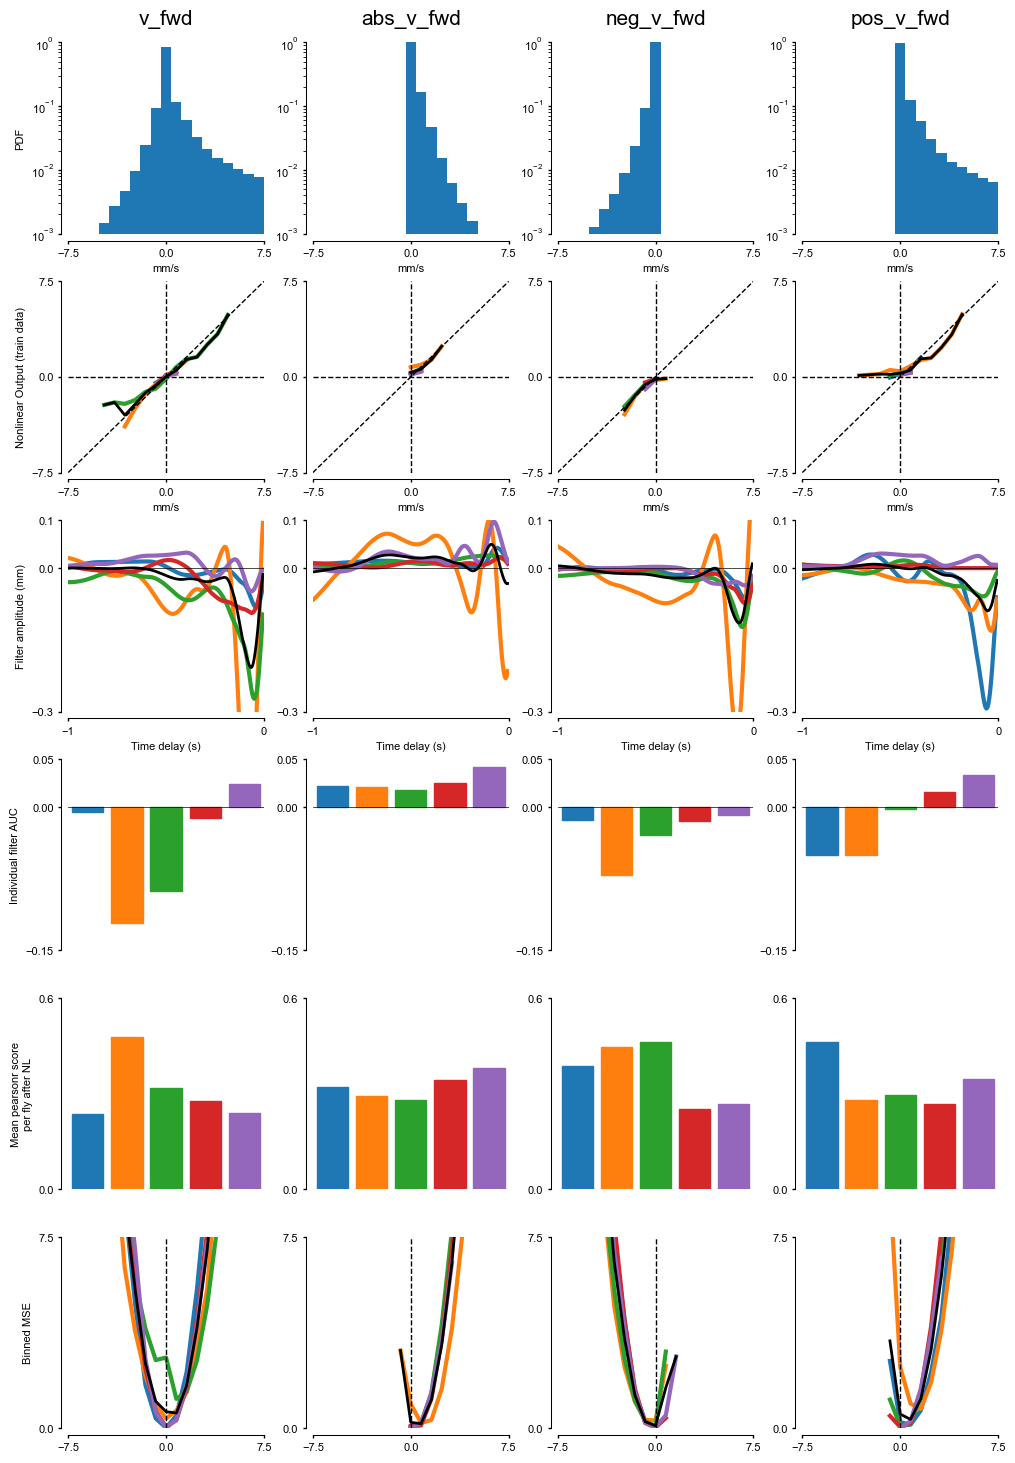

In [ ]:
top_N_scores = 5

results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
plot_upscale_factor = 0 #0.25
nbins = 20
# y_names = ['v_fwd','abs_v_fwd','neg_v_fwd','pos_v_fwd','v_ang','abs_v_ang','neg_v_ang','pos_v_ang']
y_names = ['v_fwd','abs_v_fwd','neg_v_fwd','pos_v_fwd']
T = np.arange(-int(3*subsampled_frequency), 0)/subsampled_frequency
score_threshold = 0
# value_range_dict = {'v_fwd':(-5,5),'abs_v_fwd':(0,5), 'neg_v_fwd':(-5,0), 'pos_v_fwd':(0,5),'v_ang':(-30,30),'abs_v_ang':(0,30), 'neg_v_ang':(-30,0), 'pos_v_ang':(0,30)}
fwd_range = (-7.5,7.5)
ang_range = (-100,100)
value_range_dict = {'v_fwd':fwd_range,'abs_v_fwd':fwd_range, 'neg_v_fwd':fwd_range, 'pos_v_fwd':fwd_range,'v_ang':ang_range,'abs_v_ang':ang_range, 'neg_v_ang':ang_range, 'pos_v_ang':ang_range}

fwd_lim = (-0.3,0.1)
ang_lim = (-3,3)
filter_limits_dict = {'v_fwd':fwd_lim,'abs_v_fwd':fwd_lim, 'neg_v_fwd':fwd_lim, 'pos_v_fwd':fwd_lim,'v_ang':ang_lim,'abs_v_ang':ang_lim, 'neg_v_ang':ang_lim, 'pos_v_ang':ang_lim}

fwd_auc_lim = (-0.15,0.05)
ang_auc_lim = (-3,3)
AUC_limits_dict = {'v_fwd':fwd_auc_lim,'abs_v_fwd':fwd_auc_lim, 'neg_v_fwd':fwd_auc_lim, 'pos_v_fwd':fwd_auc_lim,'v_ang':ang_auc_lim,'abs_v_ang':ang_auc_lim, 'neg_v_ang':ang_auc_lim, 'pos_v_ang':ang_auc_lim}

scores_limits = (0,0.6)

fig, axes = plt.subplots(6,len(y_names),figsize=(3*len(y_names),3*6))

for iv, varname in enumerate(y_names):
    df = load_into_pandas(dir_path=raw_data_dir_path)
    df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
    df = df[(df.to_ignore == False)&(df.DN == 'MDN')].reset_index(drop=True)
    df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]

    df_GLMresults = pd.read_pickle(f'mdn_dm_glms/res/models/df_GLM_results.pkl')
    df_GLMresults = df_GLMresults[(df_GLMresults.DN == 'MDN')&(df_GLMresults.varname == varname)]
    df_GLMresults['unique_id'] = [df.loc[df.filename == ff,'unique_id'].values[0] for ff in df_GLMresults['filename']]
    mean_scores = df_GLMresults.groupby('unique_id')['pearsonr_score'].mean()
    top_unique_ids = mean_scores.nlargest(top_N_scores).index
    df_GLMresults = df_GLMresults[df_GLMresults['unique_id'].isin(top_unique_ids)]
    unique_IDS = df_GLMresults['unique_id'].unique().tolist()

    plot_upscale = plot_upscale_factor*(value_range_dict[varname][1] - value_range_dict[varname][0])
    xmin = value_range_dict[varname][0] - plot_upscale
    xmax = value_range_dict[varname][1] + plot_upscale
    
    all_y_test = []
    bin_edges_fixed = np.linspace(xmin, xmax, nbins)

    mean_mse_list = []
    mean_statistic_list = []
    mean_flyfilter_list = []

    for unique_id in unique_IDS:

        mse_collection = []
        trial_prediction = []
        trial_statistics = []
        estimated_filters_list = []
        filename_list = df_GLMresults[df_GLMresults.unique_id == unique_id]['filename'].unique().tolist()
        for filename in filename_list:
            res_file_path = f'{raw_data_dir_path}/res/2025_glms_doublecheck_NL/{filename}_{varname}_isplit0.pkl'
            if os.path.exists(res_file_path):
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    y_test = temp['y_test'][:]
                    all_y_test.append(y_test)
                    y_pred_train = temp['y_pred_train'][:]
                    y_train = temp['y_train'][:]
                    y_pred_test = temp['y_pred_test'][:]
                    estimated_filter = temp['estimated_filters'][:]
                    
                    bin_centers = bin_edges_fixed[:-1] + np.mean(np.diff(bin_edges_fixed)) / 2

                    # print(np.sum(np.isnan(y_pred_train)),np.sum(np.isnan(y_train)))

                    statistic, bin_edges, binnumber = binned_statistic(y_pred_train, y_train, statistic='mean', bins=bin_edges_fixed, range=(xmin,xmax))
                    valid = ~np.isnan(statistic)
                    x = bin_centers[valid]
                    y = statistic[valid]
                    y_interp = np.interp(y_pred_test, x, y)
                    outside = (y_pred_test < x.min()) | (y_pred_test > x.max())
                    y_interp[outside] = y_pred_test[outside]
                    y_pred_test_nl = y_interp

                    statistic_nl, _, _ = binned_statistic(y_pred_test, y_pred_test_nl, statistic='mean', bins=bin_edges_fixed, range=(xmin,xmax))

                    bins = bin_edges_fixed
                    bin_indices = np.digitize(y_test, bins) - 1  # bin index for each sample

                    mse = np.full(nbins-1, np.nan)
                    for i in range(nbins-1):
                        idx = bin_indices == i
                        mse[i] = np.mean((y_test[idx] - y_pred_test_nl[idx])**2)

                    mse_collection.append(mse)
                    trial_statistics.append(statistic)
                    trial_prediction.append(statistic_nl)
                    estimated_filters_list.append(estimated_filter)

        unique_estimated_filter = np.nanmean(np.vstack(estimated_filters_list),axis=0)
        statistic_mean = np.nanmean(np.vstack(trial_statistics),axis=0)
        statistic_mean_afternl = np.nanmean(np.vstack(trial_prediction),axis=0)
        mse_pooled = np.nanmean(np.vstack(mse_collection),axis=0)
        mean_statistic_list.append(statistic_mean_afternl)
        mean_flyfilter_list.append(unique_estimated_filter)
        mean_mse_list.append(mse_pooled)
        axes[1,iv].plot(bin_centers, statistic_mean_afternl, lw=3, alpha=1, label='Nonlinearity')
        axes[2,iv].plot(T, unique_estimated_filter, lw=3, alpha=1, label='Fly filter')
        axes[5,iv].plot(bin_centers, mse_pooled, lw=3, alpha=1, label='Nonlinearity')
    
    ax = axes[0,iv]
    ax.hist(np.hstack(all_y_test), bins = bin_edges_fixed, density=True)
    ax.set_xlim([xmin, xmax])
    ax.set_yscale('log')
    ax.set_ylim([0.001,1])
    ax.set_title(varname,y=1.05,fontsize=15)
    
    ax = axes[1,iv]
    mean_mean_statistic = np.nanmean(np.vstack(mean_statistic_list),axis=0)
    ax.plot(bin_centers, mean_mean_statistic, 'k', lw=2, alpha=1, label='Nonlinearity')
    ax.plot([xmin, xmax], [xmin, xmax], 'k', lw=1, alpha=1, linestyle='--')
    ax.axhline(y=0, color='k', lw=1, linestyle='--')
    ax.axvline(x=0, color='k', lw=1, linestyle='--')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])

    ax = axes[2,iv]
    mean_filter = np.nanmean(np.vstack(mean_flyfilter_list),axis=0)
    ax.plot(T, mean_filter, 'k', lw=2, alpha=1, label='Mean filter')
    ax.axhline(y=0,color='k',lw=0.5)
    ax.set_ylim(filter_limits_dict[varname])

    ax = axes[3,iv]
    areas = [np.trapezoid(f, 3+T) for f in mean_flyfilter_list]
    bars = ax.bar(range(len(mean_flyfilter_list)), areas)
    for bar, color in zip(bars, plt.rcParams['axes.prop_cycle'].by_key()['color']):
        bar.set_color(color)
    ax.axhline(y=0,color='k',lw=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = axes[4,iv]   
    scores_list = [df_GLMresults[(df_GLMresults.unique_id == uID) & (df_GLMresults.varname == varname)]['pearsonr_score'].mean() for uID in unique_IDS]
    bars = ax.bar(range(len(scores_list)), scores_list)
    for bar, color in zip(bars, plt.rcParams['axes.prop_cycle'].by_key()['color']):
        bar.set_color(color)
    ax.axhline(y=0,color='k',lw=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axes[5,iv]
    mean_mean_mse = np.nanmean(np.vstack(mean_mse_list),axis=0)
    ax.plot(bin_centers, mean_mean_mse, 'k', lw=2, alpha=1, label='MSE')
    ax.axvline(x=0, color='k', lw=1, linestyle='--')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([0,xmax])

axes[0,0].set_ylabel('PDF')
axes[1,0].set_ylabel('Nonlinear Output (train data)')
axes[0,0].set_ylabel('PDF')
axes[2,0].set_ylabel('Filter amplitude (mm)')
axes[3,0].set_ylabel('Individual filter AUC')
axes[4,0].set_ylabel('Mean pearsonr score\nper fly after NL')
axes[5,0].set_ylabel('Binned MSE')

for ax in axes[0,:].flatten():
    ax.set_xlabel('')
for ax in axes[:2,:4].flatten():
    ax.set_xlabel('mm/s')
for ax in axes[:2,4:].flatten():
    ax.set_xlabel('°/s')
for ax in axes[2,:].flatten():
    ax.set_xlabel('Time delay (s)')
    ax.set_xlim([-1,0])

for iv, varname in enumerate(y_names):
    plot_upscale = plot_upscale_factor*(value_range_dict[varname][1] - value_range_dict[varname][0])
    xmin = value_range_dict[varname][0] - plot_upscale
    xmax = value_range_dict[varname][1] + plot_upscale

    ax = axes[0,iv]
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([xmin,xmax])
    ax.set_xticks([xmin,0,xmax])
    ax.spines[['left']].set_bounds([0.001,1])
    # ax.set_yticks([0.001,1])

    ax = axes[1,iv]
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([xmin,xmax])
    ax.set_xticks([xmin,0,xmax])
    ax.spines[['left']].set_bounds([xmin,xmax])
    ax.set_yticks([xmin,0,xmax])

    ax = axes[2,iv]
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([-1,0])
    ax.set_xticks([-1,0])
    ax.spines[['left']].set_bounds(filter_limits_dict[varname])
    ax.set_yticks([filter_limits_dict[varname][0],0,filter_limits_dict[varname][1]])

    ax = axes[3,iv]
    ax.set_xlim([-0.5,len(unique_IDS)-0.5])
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.set_ylim(AUC_limits_dict[varname])
    ax.set_yticks([AUC_limits_dict[varname][0],0,AUC_limits_dict[varname][1]])
    ax.spines[['left']].set_bounds(AUC_limits_dict[varname])

    ax = axes[4,iv]
    ax.set_xlim([-0.5,len(unique_IDS)-0.5])
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.set_ylim(scores_limits)
    ax.set_yticks([0,scores_limits[1]])
    ax.spines[['left']].set_bounds(scores_limits)

    ax = axes[5,iv]
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines[['bottom']].set_bounds([xmin,xmax])
    ax.set_xticks([xmin,0,xmax])
    ax.spines[['left']].set_bounds([0,xmax])
    ax.set_yticks([0,xmax])

plt.subplots_adjust(hspace=0.25,wspace=0.25)
plt.savefig(f'../fig/rebuttal/MDN_vdistribution_NL_filter_AUC_scores_top5.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()


# Close inspect abs model performance rel to fwd/bwd samples

In [4]:
isplit = 0
redo_analysis = False
bin_width = 100
decimating_values = [10,10]
starting_nbins = 50
raw_data_dir_path = 'W:/apalaci/code/janache'
sample_frequency = 20000 # 20 Hz
subsampled_frequency = int(sample_frequency/bin_width)

C:\Users\apalaci\AppData\Local\Temp\ipykernel_5260\2025446983.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r[i] = pearsonr(y_test[idx], y_pred[idx])[0]


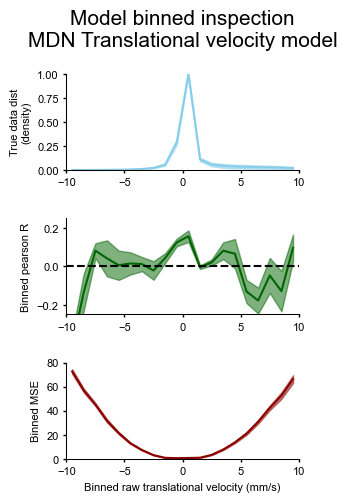

In [5]:
df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'MDN')].reset_index(drop=True)
df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]
unique_IDS = df['unique_id'].unique().tolist()
selected_df = df[df.DN == 'MDN'].reset_index(drop=True)

plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")
raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_saving_idxs'
isplit = 0
value_range_dict = {'v_fwd':(-10,10),'abs_v_fwd':(0,10),'v_ang':(-200,200),'abs_v_ang':(0,200)}
n_bins_dict = {'v_fwd':20,'abs_v_fwd':10,'v_ang':20,'abs_v_ang':10}

iv = 1
varname = 'abs_v_fwd'
ref_iv = 0
ref_varname = 'v_fwd'

fig, axes = plt.subplots(3, 1, figsize=(3,5))

# for iv, varname in enumerate(['v_fwd','abs_v_fwd','v_ang','abs_v_ang']):
all_counts, all_r, all_mse, all_probs = [], [], [], []
for index, row in selected_df.iterrows():
    filename = row['filename']
    DN_side = row['side']
    DN = row['DN']

    res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
    if os.path.exists(res_file_path):
        with open(res_file_path, 'rb') as handle:
            temp = pickle.load(handle)

            y_test = temp['y_test']
            y_pred_test_nl = temp['y_pred_test_nl']
            idx_test = temp['idx_test']
            y_m = temp['y_m']

        assert np.all(y_test == y_m[idx_test, iv])

        # bin_centers, counts, pearson_r, mse, probs
        y_true = y_m[idx_test,ref_iv]
        y_pred = y_pred_test_nl
        n_bins = n_bins_dict[ref_varname]
        value_range = value_range_dict[ref_varname]

        bins = np.linspace(value_range[0], value_range[1], n_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_indices = np.digitize(y_true, bins) - 1  # bin index for each sample

        pearson_r = np.full(n_bins, np.nan)
        mse = np.full(n_bins, np.nan)
        counts = np.zeros(n_bins, dtype=int)

        for i in range(n_bins):
            idx = bin_indices == i
            counts[i] = np.sum(idx)
            if counts[i] > 2:  # need at least 3 points for correlation
                pearson_r[i] = pearsonr(y_test[idx], y_pred[idx])[0]
                mse[i] = np.mean((y_test[idx] - y_pred[idx])**2)
        probs = counts/np.nanmax(counts)
        
        all_counts.append(counts)
        all_probs.append(probs)
        all_r.append(pearson_r)
        all_mse.append(mse)

panel_plot_pooled_analysis(axes, bin_centers, all_probs, all_r, all_mse)

axes[1].axhline(y=0, linestyle='--',color='k')
axes[1].set_ylim([-0.25,0.25])
axes[0].set_title('Model binned inspection\nMDN Translational velocity model', y=1.2,fontsize=15)
axes[-1].set_xlabel('Binned raw translational velocity (mm/s)')
plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.savefig(f'../fig/rebuttal/rebuttal_binned_stat_MDN.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [12]:
df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'MDN')].reset_index(drop=True)
df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]
unique_IDS = df['unique_id'].unique().tolist()
selected_df = df[df.DN == 'MDN'].reset_index(drop=True)

raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_saving_idxs'
isplit = 0

varname = 'abs_v_fwd'

data_for_Jan = {}

for index, row in selected_df.iterrows():
    filename = row['filename']
    DN_side = row['side']
    DN = row['DN']

    data_for_Jan[filename] = {}

    res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
    if os.path.exists(res_file_path):
        with open(res_file_path, 'rb') as handle:
            temp = pickle.load(handle)

            y_pred_test_nl = temp['y_pred_test_nl']
            y_pred_test = temp['y_pred_test']
            idx_test = temp['idx_test']
            y_m = temp['y_m']

            data_for_Jan[filename]['raw'] = y_m[idx_test, 0]
            data_for_Jan[filename]['abs'] = y_m[idx_test, 1]
            data_for_Jan[filename]['abs_pred'] = y_pred_test
            data_for_Jan[filename]['abs_pred_nl'] = y_pred_test_nl

            assert len(y_pred_test_nl) == len(y_pred_test)
            assert len(y_pred_test_nl) == len(y_m[idx_test, 0])
            assert len(y_pred_test_nl) == len(y_m[idx_test, 1])

with open(f'data_4_Jan.pkl', 'wb') as handle:
    pickle.dump(data_for_Jan, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\apalaci\AppData\Local\Temp\ipykernel_8160\2016721589.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r[i] = pearsonr(y_test[idx], y_pred[idx])[0]


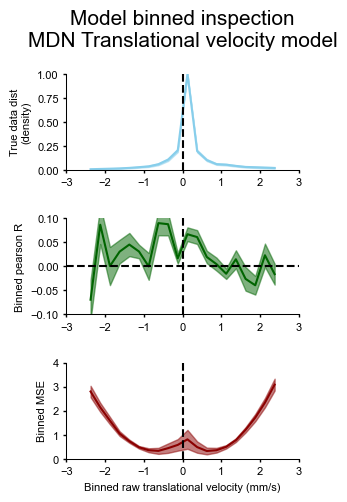

In [ ]:
df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'MDN')].reset_index(drop=True)
df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]
unique_IDS = df['unique_id'].unique().tolist()
selected_df = df[df.DN == 'MDN'].reset_index(drop=True)

plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")
raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_saving_idxs'
isplit = 0
value_range_dict = {'v_fwd':(-2.5,2.5),'abs_v_fwd':(0,2.5)}
n_bins_dict = {'v_fwd':20,'abs_v_fwd':10}

iv = 1
varname = 'abs_v_fwd'
ref_iv = 0
ref_varname = 'v_fwd'

fig, axes = plt.subplots(3, 1, figsize=(3,5))

# for iv, varname in enumerate(['v_fwd','abs_v_fwd','v_ang','abs_v_ang']):
all_counts, all_r, all_mse, all_probs = [], [], [], []
for index, row in selected_df.iterrows():
    filename = row['filename']
    DN_side = row['side']
    DN = row['DN']

    res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
    if os.path.exists(res_file_path):
        with open(res_file_path, 'rb') as handle:
            temp = pickle.load(handle)

            y_test = temp['y_test']
            y_pred_test_nl = temp['y_pred_test_nl']
            idx_test = temp['idx_test']
            y_m = temp['y_m']

        assert np.all(y_test == y_m[idx_test, iv])

        # bin_centers, counts, pearson_r, mse, probs
        y_true = y_m[idx_test,ref_iv]
        y_pred = y_pred_test_nl
        n_bins = n_bins_dict[ref_varname]
        value_range = value_range_dict[ref_varname]

        bins = np.linspace(value_range[0], value_range[1], n_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_indices = np.digitize(y_true, bins) - 1  # bin index for each sample

        pearson_r = np.full(n_bins, np.nan)
        mse = np.full(n_bins, np.nan)
        counts = np.zeros(n_bins, dtype=int)

        for i in range(n_bins):
            idx = bin_indices == i
            counts[i] = np.sum(idx)
            if counts[i] > 2:  # need at least 3 points for correlation
                pearson_r[i] = pearsonr(y_test[idx], y_pred[idx])[0]
                mse[i] = np.mean((y_test[idx] - y_pred[idx])**2)
        probs = counts/np.nanmax(counts)
        
        all_counts.append(counts)
        all_probs.append(probs)
        all_r.append(pearson_r)
        all_mse.append(mse)

panel_plot_pooled_analysis(axes, bin_centers, all_probs, all_r, all_mse)

for ax in axes.flatten():
    ax.axvline(x=0, linestyle='--',color='k')

axes[1].axhline(y=0, linestyle='--',color='k')
axes[1].set_ylim([-0.1,0.1])
axes[0].set_title('Model binned inspection\nMDN Translational velocity model', y=1.2,fontsize=15)
axes[-1].set_xlabel('Binned raw translational velocity (mm/s)')
plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.savefig(f'../fig/rebuttal/rebuttal_binned_stat_MDN_zoom.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

C:\Users\apalaci\AppData\Local\Temp\ipykernel_8160\896547634.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r[i] = pearsonr(y_test[idx], y_pred[idx])[0]


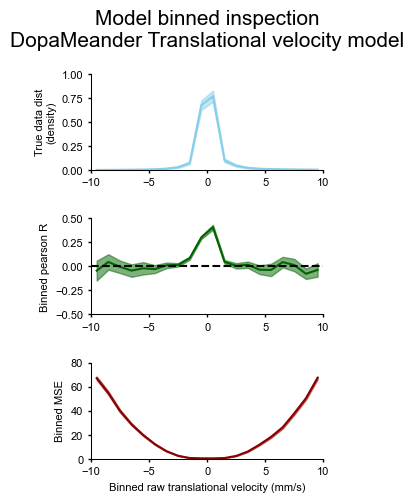

In [ ]:
df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'DopaMeander')].reset_index(drop=True)
df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]
unique_IDS = df['unique_id'].unique().tolist()
selected_df = df[df.DN == 'DopaMeander'].reset_index(drop=True)

plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")
raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_saving_idxs'
isplit = 0
value_range_dict = {'v_fwd':(-10,10),'abs_v_fwd':(0,10),'v_ang':(-200,200),'abs_v_ang':(0,200)}
n_bins_dict = {'v_fwd':20,'abs_v_fwd':10,'v_ang':20,'abs_v_ang':10}

iv = 1
varname = 'abs_v_fwd'
ref_iv = 0
ref_varname = 'v_fwd'

fig, axes = plt.subplots(3, 1, figsize=(3,5))

# for iv, varname in enumerate(['v_fwd','abs_v_fwd','v_ang','abs_v_ang']):
all_counts, all_r, all_mse, all_probs = [], [], [], []
for index, row in selected_df.iterrows():
    filename = row['filename']
    DN_side = row['side']
    DN = row['DN']

    res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
    if os.path.exists(res_file_path):
        with open(res_file_path, 'rb') as handle:
            temp = pickle.load(handle)

            y_test = temp['y_test']
            y_pred_test_nl = temp['y_pred_test_nl']
            idx_test = temp['idx_test']
            y_m = temp['y_m']

        assert np.all(y_test == y_m[idx_test, iv])

        # bin_centers, counts, pearson_r, mse, probs
        y_true = y_m[idx_test,ref_iv]
        y_pred = y_pred_test_nl
        n_bins = n_bins_dict[ref_varname]
        value_range = value_range_dict[ref_varname]

        bins = np.linspace(value_range[0], value_range[1], n_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_indices = np.digitize(y_true, bins) - 1  # bin index for each sample

        pearson_r = np.full(n_bins, np.nan)
        mse = np.full(n_bins, np.nan)
        counts = np.zeros(n_bins, dtype=int)

        for i in range(n_bins):
            idx = bin_indices == i
            counts[i] = np.sum(idx)
            if counts[i] > 2:  # need at least 3 points for correlation
                pearson_r[i] = pearsonr(y_test[idx], y_pred[idx])[0]
                mse[i] = np.mean((y_test[idx] - y_pred[idx])**2)
        probs = counts/np.nanmax(counts)
        
        all_counts.append(counts)
        all_probs.append(probs)
        all_r.append(pearson_r)
        all_mse.append(mse)

panel_plot_pooled_analysis(axes, bin_centers, all_probs, all_r, all_mse)

axes[1].axhline(y=0, linestyle='--',color='k')
axes[1].set_ylim([-0.5,0.5])
axes[0].set_title('Model binned inspection\nDopaMeander Translational velocity model', y=1.2,fontsize=15)
axes[-1].set_xlabel('Binned raw translational velocity (mm/s)')
plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.savefig(f'../fig/rebuttal/rebuttal_binned_stat_DopaMeander.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Detailed velocity distribution

In [40]:
top_N_scores = 5

results_dir_path = 'W:/apalaci/code/janache/res'
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
plot_upscale_factor = 0 #0.25
nbins = 20
# y_names = ['v_fwd','abs_v_fwd','neg_v_fwd','pos_v_fwd','v_ang','abs_v_ang','neg_v_ang','pos_v_ang']
y_names = ['v_fwd','abs_v_fwd','neg_v_fwd','pos_v_fwd']
T = np.arange(-int(3*subsampled_frequency), 0)/subsampled_frequency
score_threshold = 0
# value_range_dict = {'v_fwd':(-5,5),'abs_v_fwd':(0,5), 'neg_v_fwd':(-5,0), 'pos_v_fwd':(0,5),'v_ang':(-30,30),'abs_v_ang':(0,30), 'neg_v_ang':(-30,0), 'pos_v_ang':(0,30)}
fwd_range = (-7.5,7.5)
ang_range = (-100,100)
value_range_dict = {'v_fwd':fwd_range,'abs_v_fwd':fwd_range, 'neg_v_fwd':fwd_range, 'pos_v_fwd':fwd_range,'v_ang':ang_range,'abs_v_ang':ang_range, 'neg_v_ang':ang_range, 'pos_v_ang':ang_range}

fwd_lim = (-0.3,0.1)
ang_lim = (-3,3)
filter_limits_dict = {'v_fwd':fwd_lim,'abs_v_fwd':fwd_lim, 'neg_v_fwd':fwd_lim, 'pos_v_fwd':fwd_lim,'v_ang':ang_lim,'abs_v_ang':ang_lim, 'neg_v_ang':ang_lim, 'pos_v_ang':ang_lim}

fwd_auc_lim = (-0.15,0.05)
ang_auc_lim = (-3,3)
AUC_limits_dict = {'v_fwd':fwd_auc_lim,'abs_v_fwd':fwd_auc_lim, 'neg_v_fwd':fwd_auc_lim, 'pos_v_fwd':fwd_auc_lim,'v_ang':ang_auc_lim,'abs_v_ang':ang_auc_lim, 'neg_v_ang':ang_auc_lim, 'pos_v_ang':ang_auc_lim}

scores_limits = (0,0.6)

varname = 'v_fwd'

# for iv, varname in enumerate(y_names):
df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)&(df.DN == 'MDN')].reset_index(drop=True)
df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) for a,b in zip(df['#Fly'],df['#Cell'])]

df_GLMresults = pd.read_pickle(f'mdn_dm_glms/res/models/df_GLM_results.pkl')
df_GLMresults = df_GLMresults[(df_GLMresults.DN == 'MDN')&(df_GLMresults.varname == varname)]
df_GLMresults['unique_id'] = [df.loc[df.filename == ff,'unique_id'].values[0] for ff in df_GLMresults['filename']]
mean_scores = df_GLMresults.groupby('unique_id')['pearsonr_score'].mean()
top_unique_ids = mean_scores.nlargest(top_N_scores).index
df_GLMresults = df_GLMresults[df_GLMresults['unique_id'].isin(top_unique_ids)]
unique_IDS = df_GLMresults['unique_id'].unique().tolist()

plot_upscale = plot_upscale_factor*(value_range_dict[varname][1] - value_range_dict[varname][0])
xmin = value_range_dict[varname][0] - plot_upscale
xmax = value_range_dict[varname][1] + plot_upscale

all_y_test = []
bin_edges_fixed = np.linspace(xmin, xmax, nbins)

mean_statistic_list = []
mean_flyfilter_list = []

for unique_id in unique_IDS:
    filename_list = df_GLMresults[df_GLMresults.unique_id == unique_id]['filename'].unique().tolist()
    for filename in filename_list:
        res_file_path = f'{raw_data_dir_path}/res/2025_glms_doublecheck_NL/{filename}_{varname}_isplit0.pkl'
        if os.path.exists(res_file_path):
            with open(res_file_path, 'rb') as handle:
                temp = pickle.load(handle)
                all_y_test.append(temp['y_test'])

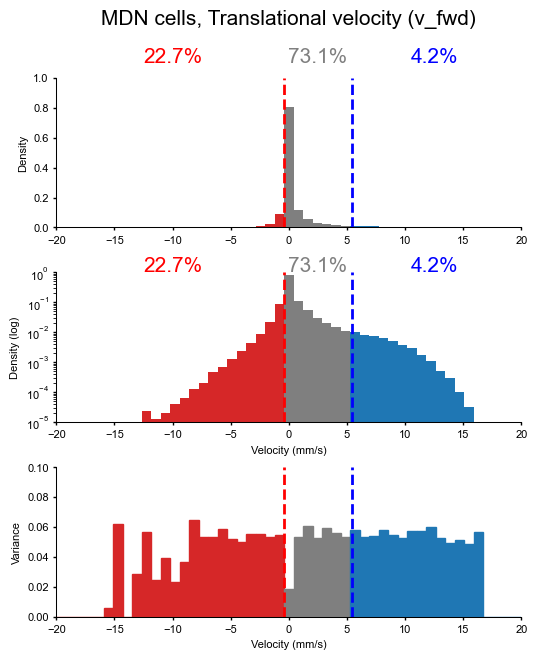

In [ ]:
Y = np.hstack(all_y_test)

fig, axes = plt.subplots(3,1,figsize=(6,7))

xmin = -20
xmax = 20
nbins = 50
bins = np.linspace(xmin, xmax, nbins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

for ax in axes[:2].flatten():
    counts, bins, patches = ax.hist(
        Y,
        bins=np.linspace(xmin, xmax, nbins),
        density=True,
        edgecolor=None
    )

    total = len(Y)
    pct_below_0 = 100 * np.sum(Y < 0) / total
    pct_above_5 = 100 * np.sum(Y > 5) / total
    pct_middle = 100 - pct_below_0 - pct_above_5

    # Recolor bars based on bin center
    for count, left, right, patch in zip(counts, bins[:-1], bins[1:], patches):
        bin_center = 0.5 * (left + right)

        if bin_center < 0:
            patch.set_facecolor("tab:red")
        elif bin_center > 5:
            patch.set_facecolor("tab:blue")
        else:
            patch.set_facecolor("tab:gray")

    # Reference lines
    ax.axvline(0-((xmax-xmin)/(2*nbins)), linestyle="--", color='r', linewidth=2)
    ax.axvline(5+((xmax-xmin)/(2*nbins)), linestyle="--", color='b', linewidth=2)
    ax.text(-10,1.1,f'{pct_below_0:.1f}%',color='r',fontsize=15,ha='center')
    ax.text(2.5,1.1,f'{pct_middle:.1f}%',color='grey',fontsize=15,ha='center')
    ax.text(12.5,1.1,f'{pct_above_5:.1f}%',color='b',fontsize=15,ha='center')
    ax.set_xlim([xmin, xmax])

ax = axes[2]
binned_variance = np.zeros(nbins-1)
for i in range(nbins-1):
    in_bin = (Y >= bins[i]) & (Y < bins[i + 1])
    if np.sum(in_bin) > 1:
        binned_variance[i] = np.var(Y[in_bin])
    else:
        binned_variance[i] = 0.0  # or np.nan if you prefer
bar_width = bins[1] - bins[0]
bars = ax.bar(bin_centers, binned_variance, width=bar_width, align="center")
for center, bar in zip(bin_centers, bars):
    if center < 0:
        bar.set_color("tab:red")
    elif center > 5:
        bar.set_color("tab:blue")
    else:
        bar.set_color("tab:gray")
ax.axvline(0-((xmax-xmin)/(2*nbins)), linestyle="--", color='r', linewidth=2)
ax.axvline(5+((xmax-xmin)/(2*nbins)), linestyle="--", color='b', linewidth=2)

# Labels
ax = axes[0]
ax.set_ylabel("Density")
ax.set_title(f"MDN cells, Translational velocity (v_fwd)",y=1.3,fontsize=15)

ax = axes[1]
ax.set_xlabel("Velocity (mm/s)")
ax.set_ylabel("Density (log)")
ax.set_yscale('log')
ax.set_ylim([0.00001,1])

ax = axes[2]
ax.set_xlabel("Velocity (mm/s)")
ax.set_ylabel("Variance")
ax.set_ylim([0,0.1])

plt.subplots_adjust(hspace=0.3)
plt.savefig(f'../fig/rebuttal/MDN_v_fwd_detailed_distribution.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# abs vs raw correlation

In [ ]:
raw_data_dir_path = 'W:/apalaci/code/janache'
bin_width = 100; decimating_values = [10,10] # bin_width = 100; decimating_values = [10,10]
y_names = ['abs_v_fwd','abs_v_ang']
sample_frequency = 20000 # 20 Hz

df = load_into_pandas(dir_path=raw_data_dir_path)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'
df = df[(df.to_ignore == False)].reset_index(drop=True)

df_plot = pd.read_pickle(f'mdn_dm_glms/res/models/df_GLM_results.pkl')
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = df_plot[(df_plot.DN == 'MDN')|(~((df_plot.DN == 'DopaMeander') & (df_plot.DN_side == 'undefined')))].copy().reset_index(drop=True)
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
filenames_in_plot = df_plot.filename.unique().tolist()
df['unique_id'] = ['fly' + str(a) + 'cell' + str(b) + 'DN' + str(c) for a,b,c in zip(df['#Fly'],df['#Cell'],df['DN'])]

unique_IDS = df['unique_id'].unique().tolist()
xcorr_rawabs_dict = {unique_id: [] for unique_id in unique_IDS}
for unique_id in tqdm(unique_IDS, total=len(unique_IDS)):
    unique_df = df.loc[df.unique_id == unique_id].reset_index(drop=True)
    for index, row in unique_df.iterrows():
        filename = row['filename']
        if filename in filenames_in_plot:
            csv_path = row['abs_file_path']
            singleDN_df = load_recording(csv_path=csv_path)
            x, ys = get_xy(singleDN_df,y_names,sample_frequency=20000,bin_width=100,decimating_values=[10,10])
            xcorr, lags = get_xcorr(ys[:,0],ys[:,1],lag_window_size=200,normalize_inputs=True)
            xcorr_rawabs_dict[unique_id].append(xcorr)

100%|██████████| 36/36 [15:33<00:00, 25.93s/it]


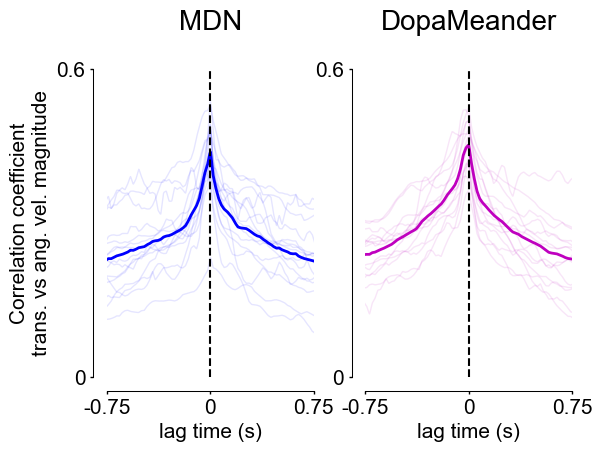

In [ ]:
clip_on = True
time_lags = lags/(sample_frequency/100)
MDN_IDs_list = df[df.DN =='MDN'].unique_id.unique().tolist()
DopaMeander_IDs_list = df[df.DN =='DopaMeander'].unique_id.unique().tolist()

fig,axes = plt.subplots(1,2,figsize=[6,4])
xlims = [-0.75,0.75]
ylims = [0,0.6]
xcorr_dict = xcorr_rawabs_dict
for ax, color, unique_IDS, title in zip(axes, ('b','m'), (MDN_IDs_list, DopaMeander_IDs_list), ('MDN','DopaMeander')):
    DN_xcorrs = []
    for unique_id in unique_IDS:
        xcorr_collection = xcorr_dict[unique_id]
        if len(xcorr_collection) > 0:
            xcorr = np.nanmean(np.vstack(xcorr_collection), axis=0)
            if color == '#840950':
                ax.plot(time_lags, xcorr, alpha=0.1, color='k',lw=1)
            else:
                ax.plot(time_lags, xcorr, alpha=0.1, color=color,lw=1)
            DN_xcorrs.append(xcorr)
    mean_trace = np.nanmean(np.vstack(DN_xcorrs), axis=0)
    sem_trace=  np.nanstd(np.vstack(DN_xcorrs) ,axis=0) / np.sqrt(np.vstack(DN_xcorrs).shape[0])
    ax.plot(time_lags, mean_trace, lw=2, color=color, clip_on=clip_on)
    ax.axvline(x=0,c='k',linestyle='--')
    # ax.axhline(y=0,c='k',linestyle='--')
    ax.set_xlim(xlims)
    ax.set_xlabel('lag time (s)',fontsize=15)
    ax.set_ylim(ylims)

    ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_bounds(xlims)
    ax.spines['left'].set_bounds(ylims)
    ax.set_xticks([xlims[0],0,xlims[1]],[xlims[0],0,xlims[1]],fontsize=15)
    # ax.set_yticks([ylims[0],0,ylims[1]],[ylims[0],0,ylims[1]],fontsize=15)
    ax.set_yticks(ylims,ylims,fontsize=15)
    ax.set_title(title,y=1.1,fontsize=20)
    ax.set_ylabel('')

axes[0].set_ylabel('Correlation coefficient\ntrans. vs ang. vel. magnitude',fontsize=15)
plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.savefig(f'../fig/rebuttal/rebuttal_xcorr_abs_vels.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()